In [1]:
import pandas as pd
import numpy as np
import random
from numpy import expand_dims

from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, roc_auc_score

from scipy.special import boxcox

from keras.preprocessing.image import ImageDataGenerator

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn')

# Digits 8 and 9 classification

In [ ]:
x_train = pd.read_csv('data_digits_8_vs_9_noisy/x_train.csv')
x_test = pd.read_csv('data_digits_8_vs_9_noisy/x_test.csv')
y_train = pd.read_csv('data_digits_8_vs_9_noisy/y_train.csv')
y_test =pd.read_csv('data_digits_8_vs_9_noisy/y_test.csv')

In [ ]:
accuracy = []
logLoss = []
coefs = []
for i in range(1, 41):
    lm_mod = LogisticRegression(solver = 'liblinear', max_iter = i)
    lm_mod.fit(x_train, y_train)
    y_prob = lm_mod.predict_proba(x_train)
    accuracy.append(lm_mod.score(x_train, y_train))
    logLoss.append(log_loss(y_train, y_prob))
    coefs.append(lm_mod.coef_[0][0])

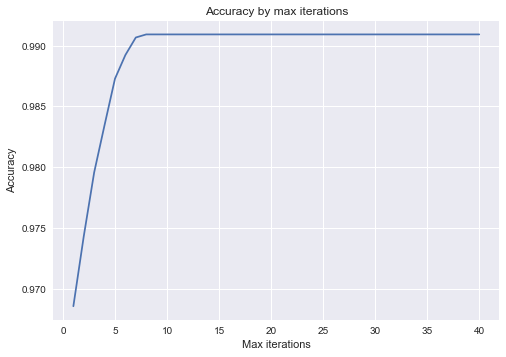

In [ ]:
i_val = np.arange(1, 41, 1)
plt.plot(i_val, accuracy);
plt.title("Accuracy by max iterations")
plt.xlabel("Max iterations")
plt.ylabel("Accuracy");

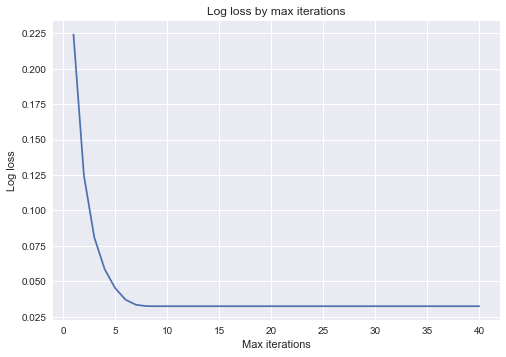

In [ ]:
plt.plot(i_val, logLoss)
plt.title("Log loss by max iterations")
plt.xlabel("Max iterations")
plt.ylabel("Log loss");

**DISCUSS:**
In the graphs, we can see that as accuracy increases sharply for the first few models, log loss also decreses. However, from the model with max iterations 7 and above, the accuracy and log loss reaches a plateau. There is no more improvement can be observed beyond this point, so we can say that the best value for max iterations is in the range 6-8.
The performance doesn't improve because the model's log loss has converged to the optimal point. Since log loss is a convex function, this is guaranteed to be the global min. This shows that it takes around 7 iterations for logistic regression fitted on this data to reach this optimal point.

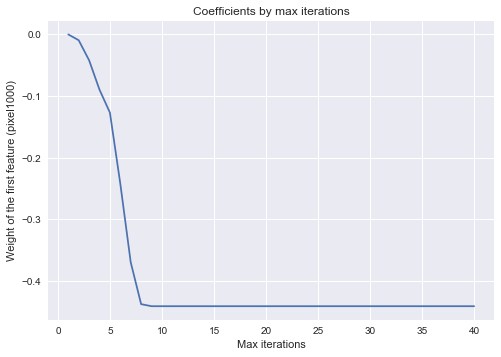

In [ ]:
plt.plot(i_val, coefs)
plt.title("Coefficients by max iterations")
plt.xlabel("Max iterations")
plt.ylabel("Weight of the first feature (pixel1000)");

**DISCUSS:**
In the graph, we see that the coefficient, or weight, of the first pixel starts off around 0, then it gets more and more negative as we increase the max iteration parameter. However, from around 7 onwards, this weight doesn't show any more changes. This corresponds to the point where the model has reached its most optimal performance based on the analysis of log loss and accuracy above. We can see that the weight of this pixel then stands at around -0.45, which leans towards digit 8 (the negative class) more, thus this pixel is deemed by the model to have some predictive ability of the number 8. This shows that there is some noise in this area in our training set of the negative class because it is not the case here that the first pixel in the model is the area of where digit 8 is. 

In [ ]:
C_grid = np.logspace(-9, 6, 31)
logLoss_C = []
for C in C_grid:
    lm_mod = LogisticRegression(C = C, solver = 'liblinear')
    lm_mod.fit(x_train, y_train)
    y_prob = lm_mod.predict_proba(x_test)
    logLoss_C.append(log_loss(y_test, y_prob))

In [ ]:
minval = min(logLoss_C)
idx = logLoss_C.index(minval)
best_C = C_grid[idx]
print("The value of C that gives the best model is: {}".format(best_C))

The value of C that gives the best model is: 0.03162277660168379


In [ ]:
# fit another model with the best parameter
best_C_model = LogisticRegression(C = best_C, solver = 'liblinear')
best_C_model.fit(x_train, y_train)
print("The accuracy score of the best model is: {}".format(best_C_model.score(x_test, y_test)))
y_pred = best_C_model.predict(x_test)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


The accuracy score of the best model is: 0.9672213817448311


In [ ]:
cm = confusion_matrix(y_test, y_pred) 
cm_df = pd.DataFrame(data=cm, columns=[0, 1], index=[0, 1])
cm_df.columns.name = 'Predicted'
cm_df.index.name = 'True'
print(cm_df)

Predicted    0    1
True               
0          942   32
1           33  976


In [ ]:
false_pos = []
false_neg = []
for i in range(len(y_test)):
    if y_pred[i] == 1 and y_test.iloc[i,0] == 0:
        false_pos.append(i)
    elif y_pred[i] == 0 and y_test.iloc[i,0] == 1:
        false_neg.append(i)

print(len(false_pos))
print(len(false_neg))

32
33


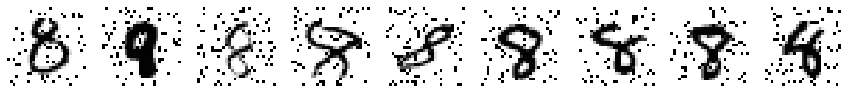

In [ ]:
idxFP = random.sample(false_pos, 9)
x_vizFP = x_test.iloc[idxFP,:].reset_index(drop=True)
labelFP = y_test.iloc[idxFP,:].reset_index(drop=True)

fig, axes = plt.subplots(1, 9, figsize=(15,5))
for ax,i in zip(axes, range(9)):
    ax.set_axis_off()
    img = x_vizFP.iloc[i,:].to_numpy()
    img = img.reshape(28,28)
    ax.imshow(img, vmin=0, vmax=1.0, cmap="Greys")

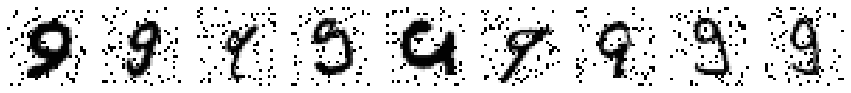

In [ ]:
idxFN = random.sample(false_neg, 9)
x_vizFN = x_test.iloc[idxFN,:].reset_index(drop=True)
labelFN = y_test.iloc[idxFN,:].reset_index(drop=True)

fig, axes = plt.subplots(1, 9, figsize=(15,5))
for ax,i in zip(axes, range(9)):
    ax.set_axis_off()
    img = x_vizFN.iloc[i,:].to_numpy()
    img = img.reshape(28,28)
    ax.imshow(img, vmin=0, vmax=1.0, cmap="Greys")

**DISCUSS:**
The model is misclassifying some instances of the digit 8 as 9 and vice versa. These wrong predictions might be due to the fact that the predict function of the model, by default, uses 0.5 threshold to make the decisions. Another reason is that these numbers are written poorly, with some being placed pretty slanted on the paper. Some number 8s have a very big upper loop and smaller lower loop, making it look like number 9. Vice versa, some number 9s are slanted, which can make the model mistaken it with the slanted stroke in number 8. 

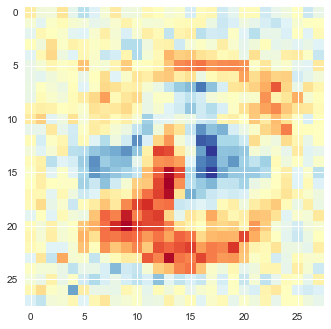

In [ ]:
coefs_reshaped = best_C_model.coef_[0]
coefs_reshaped = coefs_reshaped.reshape(28, 28)

plt.imshow(coefs_reshaped, cmap='RdYlBu', vmin=-0.5, vmax=0.5)

**DISCUSS:**
The pixels that correspond to an 8 (have negative weights) are red in hue. Pixels that correspond to a 9 (have positive weights) are more blue in hue. The red region corresponds to the loops of number 8, especially the lower loop, and the dark blue region corresponds to the downward stroke in number 9. There are also other light red, blue areas towards the borders, representing the noises in the images of these handwritten numbers, that may contribute to the classification/misclassification of these instances.

# Shirts classification

The process for this task:
- Fit a cross validation logistic regression on base model (no hyperparameter tuning). For this and all other models, the training data provided is split into a train and test set, and we will keep track of the training and the true AUROC and accuracy scores to evaluate the performance.
- Feature engineering: we're going to try different feature engineering techniques on the dataset. On examining a new feature, we are going to try a few different models that make use of different combinations of old and new features in the dataset to see which combination yields the best result. 
- Finally, we are going to tune the parameters of the best model we obtain from the previous step

First, we read in and look at the provided datasets

In [3]:
train_shirt_x = pd.read_csv('data_shirts/train_shirt_x.csv')
train_shirt_y = pd.read_csv('data_shirts/train_shirt_y.csv')
test_shirt_x = pd.read_csv('data_shirts/test_shirt_x.csv')

In [ ]:
train_shirt_x.head(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0041,0.0000,...,0.3480,0.3320,0.0000,0.0,0.004,0.0000,0.0000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0106,0.0046,0.0000,0.0000,...,0.3098,0.3589,0.3577,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0000,0.0043,0.0000,0.0000,0.0041,0.0042,...,0.0080,0.0000,0.0000,0.0,0.224,0.6392,0.5909,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0051,0.0049,0.0000,0.0000,0.0000,0.0039,...,0.1569,0.1290,0.0285,0.0,0.000,0.0045,0.0000,0.0,0.0,0.0


In [ ]:
train_shirt_y.head(5)

,is_teeshirt
0,0
1,1
2,1
3,0
4,1


In [4]:
# create a full dataset for more convenient data exploration and model fitting
full_train = train_shirt_x.copy()
full_train['is_tshirt'] = train_shirt_y['is_teeshirt']

In [ ]:
full_train.head(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,is_tshirt
0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0041,0.0000,...,0.3320,0.0000,0.0,0.004,0.0000,0.0000,0.0,0.0,0.0,0
1,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0106,0.0046,0.0000,0.0000,...,0.3589,0.3577,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,1
3,0.0,0.0,0.0,0.0,0.0000,0.0043,0.0000,0.0000,0.0041,0.0042,...,0.0000,0.0000,0.0,0.224,0.6392,0.5909,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0051,0.0049,0.0000,0.0000,0.0000,0.0039,...,0.1290,0.0285,0.0,0.000,0.0045,0.0000,0.0,0.0,0.0,1


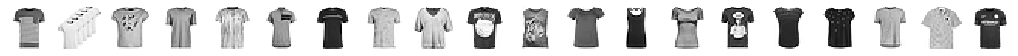

In [ ]:
# examine some instances of tshirts
fig, axes = plt.subplots(1, 20, figsize=(18,5))
viz_tshirt = full_train[full_train['is_tshirt']==1][:20]
for ax, i in zip(axes, range(20)):
    tshirt = viz_tshirt.iloc[i,:784].to_numpy()
    tshirt = tshirt.reshape(28, 28)
    ax.set_axis_off()
    ax.imshow(tshirt)

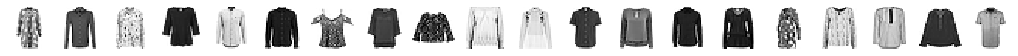

In [ ]:
# examine some instances of non tshirts
fig, axes = plt.subplots(1, 20, figsize=(18,5))
viz_nontshirt = full_train[full_train['is_tshirt']==0][:20]
for ax, i in zip(axes, range(20)):
    non_tshirt = viz_nontshirt.iloc[i,:784].to_numpy()
    non_tshirt = non_tshirt.reshape(28, 28)
    ax.set_axis_off()
    ax.imshow(non_tshirt)

## 1. Base model

The base model does no transformation and tuning. The AUC and accuracy scores on both training and testing splits are recorded

In [71]:
# train-test split
X_train_base, X_test_base, y_train_base, y_test_base = train_test_split(train_shirt_x, train_shirt_y, test_size=0.15, random_state=42)

In [72]:
base_lrcv = LogisticRegressionCV(cv=4, max_iter = 500)
base_lrcv.fit(X_train_base, y_train_base)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iteratio

LogisticRegressionCV(Cs=10, class_weight=None, cv=4, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=500, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)

In [80]:
def calc_metrics(model, x_train, y_train, x_test, y_test):
    """ Calculate and print the evaluation scores (AUROC and accuracy) for a given model
    
    Args
    ----
    model: Logistic Regression CV model that has been fitted on x_train and y_train sets
    x_train: the training data
    y_train: the training labels
    x_test: the testing data
    y_test: the testing labels
    
    Returns
    ----
    Training and testing accuracy scores. All the calculated metrics are printed to the screen.
    
    """
    train_proba = model.predict_proba(x_train)[:,1]
    train_auc = roc_auc_score(y_train, train_proba)

    test_proba = model.predict_proba(x_test)[:,1]
    test_auc = roc_auc_score(y_test, test_proba)
    
    train_acc = model.score(x_train, y_train)
    test_acc = model.score(x_test, y_test)
    
    print("The training AUC score is {}".format(train_auc))
    print("The testing AUC score is {}".format(test_auc))
    print("")
    print("The training accuracy is: {}".format(train_acc))
    print("The testing accuracy is: {}".format(test_acc))
    
    return train_acc, test_acc

In [ ]:
base_train_acc, base_test_acc = calc_metrics(base_lrcv, X_train_base, y_train_base, X_test_base, y_test_base)

The training AUC score is 0.9432745601624015
The testing AUC score is 0.9381484683794467

The training accuracy is: 0.8700980392156863
The testing accuracy is: 0.8611111111111112


## Box Cox Transform pixel features

In the first part, we are applying Boxcox transformation technique, which is usually used for making the distribution of a feature more Gaussian-like. It is important to note that normality Logistic Regression models don't assume normality, though. Therefore, this may not result in a significant increase in the performance. However, we still examine the effect of standardizing these set of features and the added features to a different range other than the [0,1] range to compare their effects

In [ ]:
# Testing a range of lambda to see which yields the best result
lambd = np.linspace(0.1, 0.9, 9)
lambd

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [ ]:
trainAcc = []
testAcc = []
for l in lambd:
    boxcox_xtrain = boxcox(train_shirt_x, l)
    xtr, xte, ytr, yte = train_test_split(boxcox_xtrain, train_shirt_y, test_size=0.15, random_state=42)
    boxcox_lrcv = LogisticRegressionCV(cv=4, max_iter = 500)
    boxcox_lrcv.fit(xtr, ytr)
    print("Lambda value: {}".format(l))
    train_acc, test_acc = calc_metrics(boxcox_lrcv, xtr, ytr, xte, yte)
    trainAcc.append(train_acc)
    testAcc.append(test_acc)

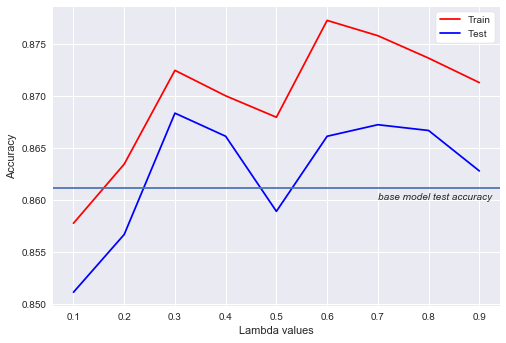

In [ ]:
fig, ax = plt.subplots(sharey=True)
ax.plot(lambd, trainAcc, color="red", label="Train")
ax.plot(lambd, testAcc, color="blue", label="Test")
ax.text(0.7, 0.86, 'base model test accuracy', fontsize=10, style='italic')
plt.xlabel("Lambda values")
plt.ylabel("Accuracy")
plt.axhline(base_test_acc, 0, 1)
plt.legend(frameon=True, framealpha=1,facecolor='white')
plt.show()

Out of these different lambda values, 0.3 is the model with the best testing accuracy, though not a significant jump from the baseline model. The training accuracy is also comparatively good as well. So we are going to use this value to create a boxcox-transformed dataset that is going to be used for future comparison. 

In [5]:
# create a boxcox-transformed dataset
boxcox_df = boxcox(train_shirt_x, 0.3) 

## 2.1 Feature Engineering: Count total number of dark pixels

The most immediate feature that can be derived from our provided dataset is to count the total number of dark pixels for each item. One hypothesis is that this feature can help the model distinguish between tshirts and non-tshirts if the distribution of this feature for tshirt is different from that of non-tshirt. In this section, we will explore the distribution and characteristics of this feature, and how it impacts the performance.

In [6]:
# count total number of dark pixels
def count_spot(x):
    """
    Count the total number of dark pixels (any pixel that is not 0) in an image (a row)
    
    Args
    ----
    x: array-like or Series
    
    Returns
    ----
    The total number of dark pixels in that array
    """
    count = 0
    for i in range(784):
        if x[i] > 0:
            count+=1
    return count

In [7]:
# count the total dark pixels on the original training data
num_spots = []
for img in range(len(train_shirt_x)):
    count = count_spot(train_shirt_x.iloc[img,:])
    num_spots.append(count)

In [8]:
# fe_ dataframe represents the modification made on the boxcox-transformed dataset
fe1 = boxcox_df.copy()
fe1['num_spots'] = num_spots
fe1['is_tshirt'] = train_shirt_y['is_teeshirt']

In [ ]:
fe1.head(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots,is_tshirt
0,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.692546,-3.333333,...,-3.333333,-3.333333,-2.697275,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,397,0
1,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.481273,-2.670039,-3.333333,-3.333333,...,-0.884640,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,450,1
2,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,...,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,519,1
3,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.683324,-3.333333,-3.333333,-2.692546,-2.687897,...,-3.333333,-3.333333,-1.205424,-0.418795,-0.486691,-3.333333,-3.333333,-3.333333,492,0
4,-3.333333,-3.333333,-3.333333,-3.333333,-2.649186,-2.657348,-3.333333,-3.333333,-3.333333,-2.702088,...,-2.186944,-3.333333,-3.333333,-2.674398,-3.333333,-3.333333,-3.333333,-3.333333,553,1


In [9]:
def standardize_num_spot(df):
    """
    Use min-max scaler technique to scale the num_spot column in the df to the range [0,1]
    
    Args:
    ----
    df: The dataframe to be modified
    
    Return:
    ----
    The modified dataframe
    
    """
    df['num_spots'] = (df['num_spots'] - min(df['num_spots']))/(max(df['num_spots']) - min(df['num_spots']))
    return df
def boxcox_trans(df):
    """
    Use boxcox transformation technique to scale the num_spot column in the df to the range [0,1]
    
    Args:
    ----
    df: The dataframe to be modified
    
    Return:
    ----
    The modified dataframe
    
    """
    df['num_spots'] = boxcox(df['num_spots'], 0.3)
    return df

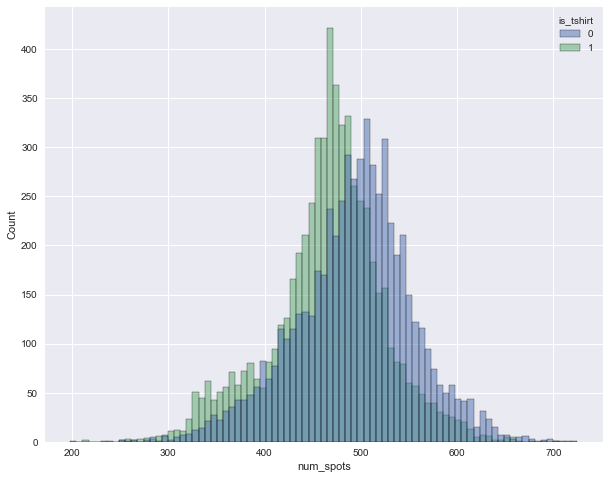

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.histplot(data = fe1, x = "num_spots", hue="is_tshirt")

The distribution of total black pixels between tshirts and non-tshirts differ a bit, which means it might have some certain prediction capability. We will fit 2 models, one with the original pixel features, and one where these pixel features are boxcox-transformed.

In [ ]:
# create a function for reusability
def tot_dark_pixels_lrcv(x_df, y_df, standardized=True, boxcox=False):
    """
    Preprocess the added feature, total number of dark spots, and fit Logistic Regression CV model on the dataset
    
    Args
    ----
    x_df: The full dataset to work on, this set is going to be split into testing and training sets
    y_df: The labels corresponding to x_df
    standardized: Whether the num_spots column has already been standardized or not, default ot True
    boxcox: Whether x_df is a boxcox-transformed dataframe or not, default to False
    
    Return
    ----
    None. The metrics (AUC and accuracy) will be printed out.
    
    """
    if standardized == False:
        if boxcox == False:
            x_df2 = standardize_num_spot(x_df)
        else:
            x_df2 = boxcox_trans(x_df)
    else:
        x_df2 = x_df.copy()
    x_train, x_test, y_train, y_test = train_test_split(x_df2, y_df, test_size=0.15, random_state=42)
    lrcv = LogisticRegressionCV(cv=4, max_iter=500)
    lrcv.fit(x_train, y_train)
    calc_metrics(lrcv, x_train, y_train, x_test, y_test)

In [ ]:
# model with boxcox-transformed features
tot_dark_pixels_lrcv(fe1.drop('is_tshirt', axis=1), train_shirt_y, standaridized = False, boxcox = True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9484221210629922
The testing AUC score is 0.9435350790513835

The training accuracy is: 0.8727450980392157
The testing accuracy is: 0.8672222222222222


In [ ]:
# model without boxcox-transformed features
full_train['num_spots'] = num_spots
tot_dark_pixels_lrcv(full_train.drop('is_tshirt', axis=1), train_shirt_y, standardized = False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9433745617002953
The testing AUC score is 0.9382139328063241

The training accuracy is: 0.8708823529411764
The testing accuracy is: 0.8605555555555555


**Discuss:** We can see that the result of the model without boxcox transformation is not as good as the baseline model, and the one with the transformation is just better by 0.1-0.2%. Compared to the model on the boxcox-transformed pixels without the feature num_spots, this model doesn't perform any better. So the difference that the feature "total number of spots" makes to the model is unsubstantial, and this is even more negligible if we have a smaller dataset. However, we will still keep record of this feature to see if it can improve the model when combined with some other features.

## 2.2 Feature Engineering: Data augmentation by flipping horizontally

The second feature engineering technique that we try is to increase the number of data points in the model, which, specifically for this section, is to flip the image horizontally, doubling the size of the original data. By augmenting the dataset, the model has more instances of each class to learn. And since each item is symmetrical, doubling the size of the input means the model can better learn the pattern of tshirts and non-tshirts, hence being able to predict new instances more accurately

In [ ]:
# create some functions to flip the image
def swap(arr, a, b):
    """
    Swap 2 elements in an array
    """
    temp = arr[a]
    arr[a] = arr[b]
    arr[b] = temp
    return arr

def FlipRow(row, columns):
    """
    Takes in an array, and reverse this array
    """
    for index in range(int(columns / 2)):
        new_row = swap(row, index, columns-1-index)
    return new_row

def HFlipArray(array, columns,rows):
    """
    Takes in an ndarray, and reverse every rows in this array
    """
    for row in range(rows):
        array[row] = FlipRow(array[row], columns)
    return array

In [ ]:
# function to create a dataframe with flipped images
def more_data(df):
    """
    Create a dataframe of flipped images from the original data
    
    Args:
    ----
    df: the original data 
    
    Return:
    ----
    A new dataframe of the same size as the original data
    
    """
    more_data = pd.DataFrame(columns = train_shirt_x.columns)

    for i in range(len(df)):
        img = df.iloc[i,:784].to_numpy()
        img = img.reshape(28, 28) # turn each row into an image
        new_img = HFlipArray(img, 28, 28) # flip the image
        new_img = new_img.reshape(784, 1).transpose() # reshape and flatten into 1d numpy array
        more_data.loc[len(more_data)] = new_img.flatten()
    return more_data

Firstly, we will fit 2 models, one on the augmented dataset with the num_spots column with boxcox transformation, and the other on the set without this transformation (and only num_spots goes through min-max scaling).

In [ ]:
# create the flipped image dataframes, one with boxcox transformation, and one without
data2X = more_data(full_train)
data2X_standard = more_data(fe1)

In [ ]:
label2X = train_shirt_y['is_teeshirt'].append(train_shirt_y['is_teeshirt'], ignore_index= True)

In [ ]:
data2X_numspots = data2X.copy()
data2X_standard_numspots  = data2X_standard.copy()
data2X_numspots['num_spots'] = num_spots
data2X_numspots['is_tshirt'] = train_shirt_y['is_teeshirt']
data2X_standard_numspots['num_spots'] = num_spots
data2X_standard_numspots['is_tshirt'] = train_shirt_y['is_teeshirt']

In [ ]:
full_train2x = pd.concat([data2X_numspots, full_train], axis=0).reset_index(drop=True)
full_train2x.tail(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots,is_tshirt
23995,0.0,0.0,0.0,0.0,0.0,0.0130,0.0000,0.000,0.0000,0.0546,...,0.0000,0.0000,0.624,0.6902,0.3182,0.2202,0.0,0.0,562,0
23996,0.0,0.0,0.0,0.0,0.0,0.0049,0.0053,0.000,0.0000,0.0000,...,0.2561,0.0000,0.000,0.0089,0.0000,0.0000,0.0,0.0,457,1
23997,0.0,0.0,0.0,0.0,0.0,0.0049,0.0000,0.000,0.0000,0.0000,...,0.2683,0.0000,0.000,0.0000,0.0000,0.0000,0.0,0.0,443,1
23998,0.0,0.0,0.0,0.0,0.0,0.0000,0.2434,0.338,0.0000,0.0235,...,0.0163,0.1373,0.000,0.0000,0.0000,0.0000,0.0,0.0,407,1
23999,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0083,0.0000,...,0.0706,0.6032,0.296,0.2118,0.0000,0.0000,0.0,0.0,487,0


In [ ]:
fe2 = pd.concat([data2X_standard_numspots, fe1], axis=0).reset_index(drop=True)
fe2.tail(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots,is_tshirt
23995,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.427472,-3.333333,-3.333333,-3.333333,-1.940059,...,-3.333333,-3.333333,-0.439762,-0.350897,-0.969108,-1.216318,-3.333333,-3.333333,562,0
23996,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.657348,-2.641245,-3.333333,-3.333333,-3.333333,...,-1.118191,-3.333333,-3.333333,-2.524804,-3.333333,-3.333333,-3.333333,-3.333333,457,1
23997,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.657348,-3.333333,-3.333333,-3.333333,-3.333333,...,-1.087048,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,443,1
23998,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-1.151734,-0.925903,-3.333333,-2.251403,...,-2.363862,-1.496034,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,407,1
23999,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.541558,-3.333333,...,-1.828390,-0.469042,-1.019851,-1.240876,-3.333333,-3.333333,-3.333333,-3.333333,487,0


In [ ]:
tot_dark_pixels_lrcv(fe2.drop('is_tshirt', axis=1), fe2.iloc[:,785:], standardized = False, boxcox = True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9428105558969702
The testing AUC score is 0.9394226635236909

The training accuracy is: 0.8644117647058823
The testing accuracy is: 0.8611111111111112


In [ ]:
tot_dark_pixels_lrcv(full_train2x.drop('is_tshirt', axis=1), full_train2x.iloc[:,785:], standardized = False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9450864617378685
The testing AUC score is 0.9353469257150764

The training accuracy is: 0.8698529411764706
The testing accuracy is: 0.8608333333333333


From the metrics calculated, both of these models are not better than the baseline model. The augmentation of data doesn't help improve the accuracy. We try fitting the model on the augmented dataset that does not have the num_spots variable.

In [ ]:
fe3_wo_numspot = pd.concat([boxcox(data2X, 0.3), boxcox_df], axis=0).reset_index(drop=True)
fe3_wo_numspot.head(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,...,-3.333333,-3.333333,-2.702088,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333
1,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.397305,-3.333333,-3.333333,-3.333333,-3.333333,...,-0.801141,-1.110438,-3.333333,-2.431676,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333
2,-3.333333,-3.333333,-3.333333,-2.291808,-3.333333,-0.754483,-0.235506,-0.677148,-0.708319,-0.496267,...,-1.300954,-1.110438,-1.111211,-1.084790,-1.062987,-0.757399,-1.385914,-3.333333,-3.333333,-3.333333
3,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.692546,-2.538708,-2.423313,...,-3.333333,-3.333333,-3.333333,-0.886284,-0.198416,-0.390928,-3.333333,-3.333333,-3.333333,-3.333333
4,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-1.288669,-0.757399,...,-1.365830,-1.432405,-1.544904,-3.333333,-3.333333,-2.649186,-3.333333,-3.333333,-3.333333,-3.333333


In [ ]:
tot_dark_pixels_lrcv(fe3_wo_numspot, label2X)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9427379379874004
The testing AUC score is 0.9393364911344364

The training accuracy is: 0.8638725490196079
The testing accuracy is: 0.8605555555555555


The model also doesn't show any improvement from the baseline model. This shows data augmentation by flipping the images doesn't help improve the model's performance.

## 2.3 Feature Engineering: Data Augmentation with ImageGenerator

In this section, we make use of an image generator function from keras library. This function is specifically used for image data augmentation, supporting a wide range of transformations to generate additional images for our model, such as flipping, shifting, zooming and brightness, as well as handling standardization/rescaling post-transformation. We will explore to see if this library can help us achieve a better performing model. We will generate and fit 2 models, one on the boxcox-transformed dataset and the other on the original set.

In [ ]:
imgen = train_shirt_x.copy()
boxcox_imgen = boxcox_df.copy()

In [ ]:
# reshape to be compatible with our datagen model
x_reshaped = train_shirt_x.to_numpy().reshape((train_shirt_x.shape[0], 28, 28, 1))
boxcox_reshaped = boxcox_df.to_numpy().reshape((boxcox_df.shape[0], 28, 28, 1))

# defining our image generating model
datagen = ImageDataGenerator(rotation_range=10, # rotation within 10 degrees
        width_shift_range=0.2, # horizontal shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2],
        rescale=1./255)

In [ ]:
# fit the model
datagen.fit(x_reshaped)

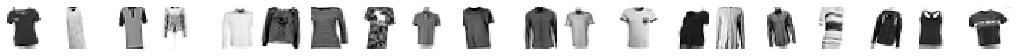

In [ ]:
# visualize some of our transformed items
fig, axes = plt.subplots(1, 20,figsize=(18,5))

for ax in axes:
    ax.imshow(np.squeeze(datagen.flow(x_reshaped, batch_size=1).next()[0]))
    ax.set_axis_off()
plt.show()

In [ ]:
# reshape and put our generated data points into a dataframe of the same as our initial training data
add_data = pd.DataFrame(datagen.flow(x_reshaped, batch_size=12000).next().reshape(12000, 784), columns=imgen.columns)

In [ ]:
# create a concatenated dataframe with doubled size
imgen = pd.concat([add_data, imgen], axis=0).reset_index(drop=True)

In [ ]:
# fit LogisticRegressionCV on the augmented dataset
tot_dark_pixels_lrcv(imgen, label2X)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.7899257399933194
The testing AUC score is 0.774056613097709

The training accuracy is: 0.6919607843137255
The testing accuracy is: 0.6763888888888889


In [ ]:
# create another model to fit on the boxcox-transformed set with similar procedure
datagen_boxcox = ImageDataGenerator(rotation_range=10, # rotation
        width_shift_range=0.2, # horizontal shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2])

In [ ]:
datagen_boxcox.fit(boxcox_reshaped)
add_data_boxcox = pd.DataFrame(datagen_boxcox.flow(boxcox_reshaped, batch_size=12000).next().reshape(12000, 784), columns=boxcox_imgen.columns)
add_data_boxcox = boxcox(add_data_boxcox, 0.3)
boxcox_imgen = pd.concat([add_data_boxcox, boxcox_imgen], axis=0).reset_index(drop=True)


In [ ]:
tot_dark_pixels_lrcv(boxcox_imgen, label2X)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.7407459792266066
The testing AUC score is 0.6974240323983474

The training accuracy is: 0.6817156862745098
The testing accuracy is: 0.6513888888888889


**DISCUSS:** This data augmentation technique also doesn't improve the model, it makes the model worse. This may be because, unlike a lot of neural network models, logistic regression cannot learn the edges and shape of the objects, it can only fit a model to the data by giving the features certain weighs. Thus, by introducing lots of variations into the data, such as making the tshirt bigger with zooming, breaking the uniform black-to-white, item-to-canvas ratio of other images in the original dataset, we make the roles of each feature less deterministic, having less predictive capability. The performance will suffer for that reason and thus should not be incorporated into this model

## 2.4 Feature Engineering: Analyze the pixel pattern around sleeve area

The final transformation we will try on our dataset is to create a variable that will count the number of dark pixels around the sleeve area of the item. The idea is that a lot of these non tshirt items in this dataset are long-sleeved. We will engineer this characteristics to see if it can help the model distinguish between tshirt and non tshirt items. 

To achieve this, we first reshape and split the image into 3 parts with appropriate ratio, then we will keep track of the sleeve parts and count the number of dark spots of them.

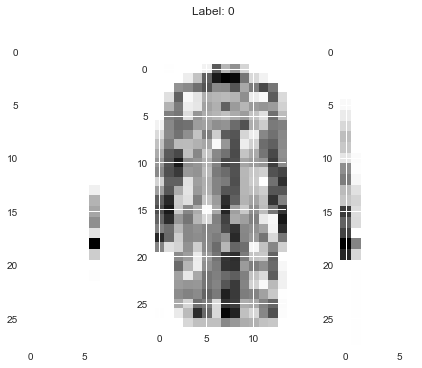

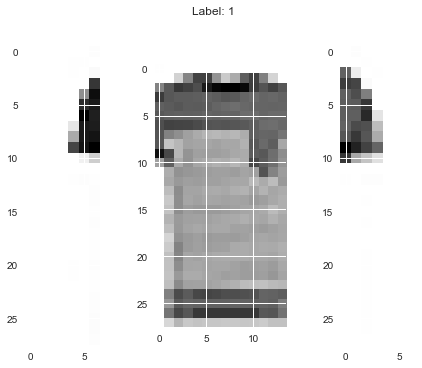

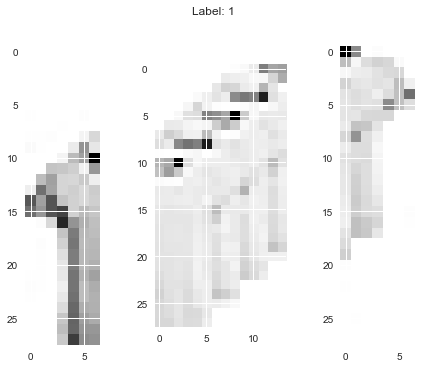

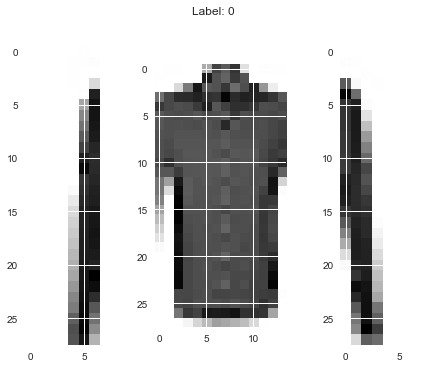

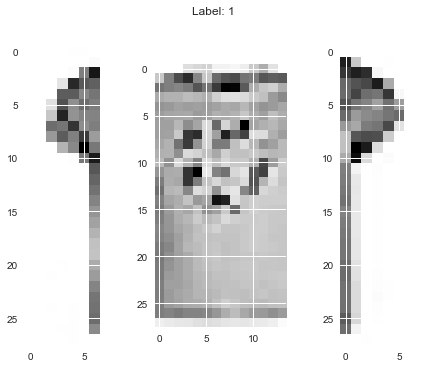

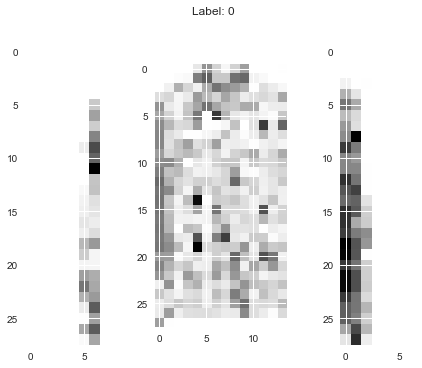

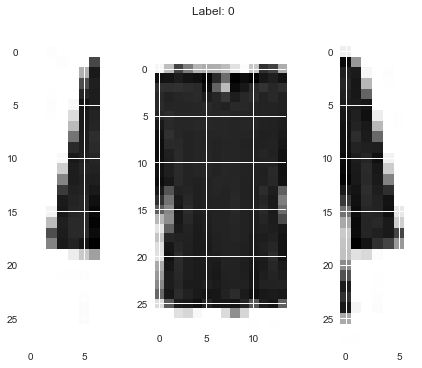

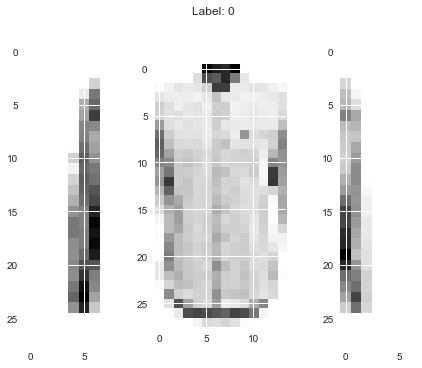

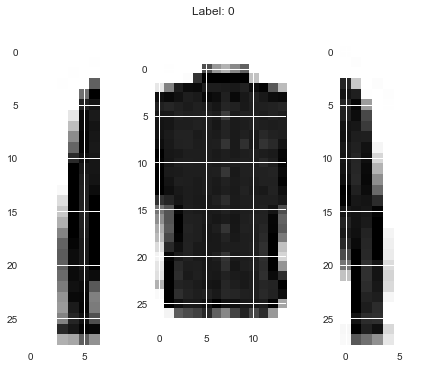

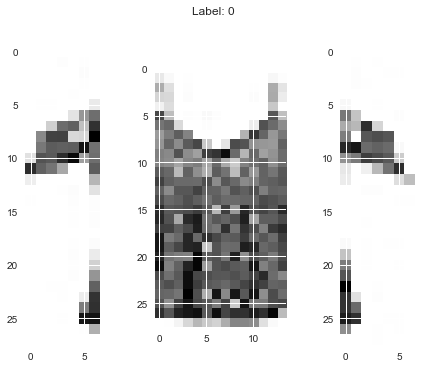

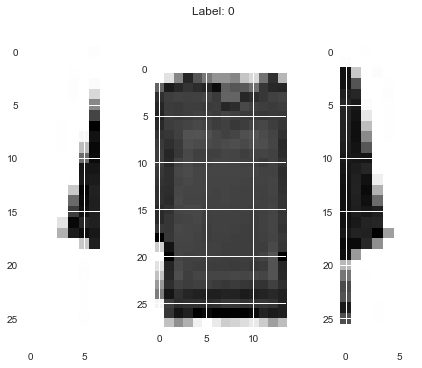

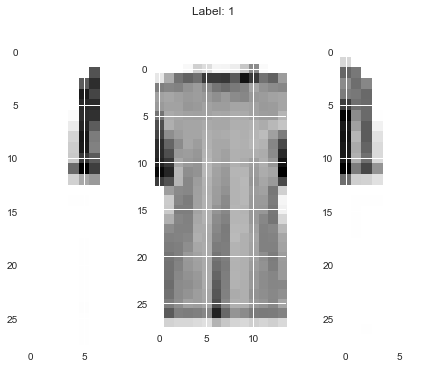

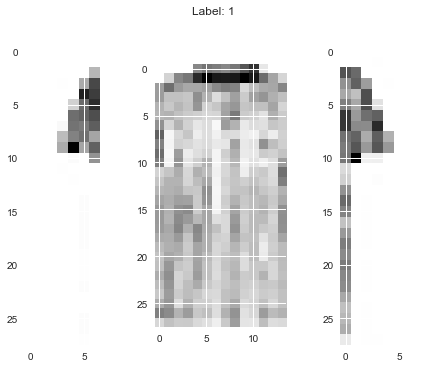

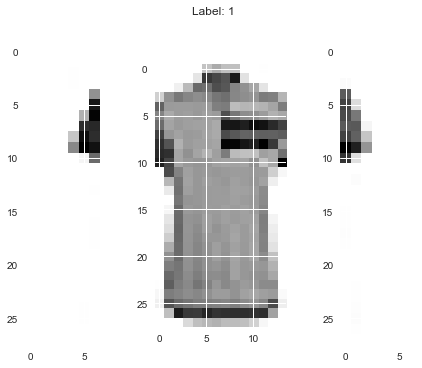

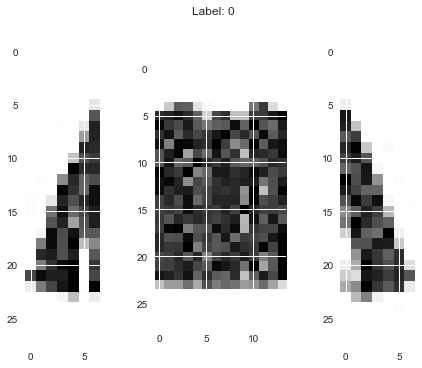

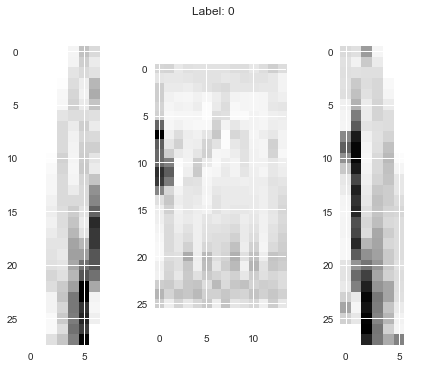

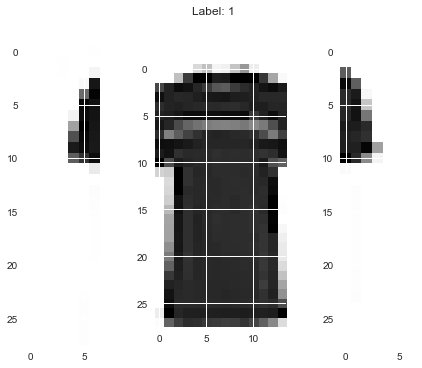

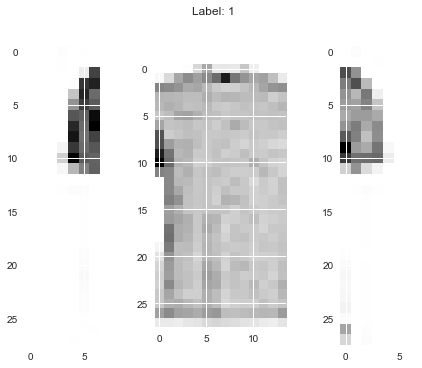

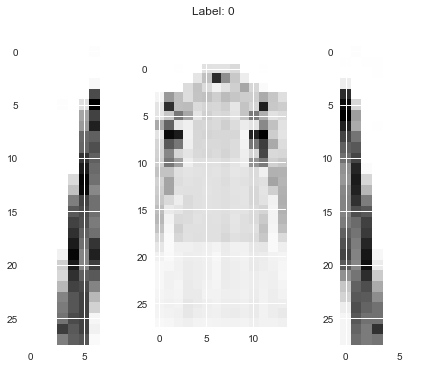

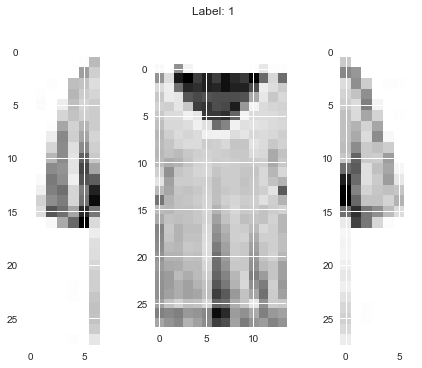

In [ ]:
# visualize some the left, middle and right parts after
for i in range(20):
    d = full_train.iloc[i,:784].to_numpy().reshape(28,28)
    d1 = d[:, :7]
    d2 = d[:, 7:21]
    d3 = d[:, 21:28]
    fig, ax = plt.subplots(1, 3)
    fig.suptitle("Label: {}".format(train_shirt_y.iloc[i,0]))
    ax[0].imshow(d1)
    ax[1].imshow(d2)
    ax[2].imshow(d3)

In [10]:
def count_spot_sleeve(x):
    """
    The shape of the sleeve area is 28x7 = 196, hence we create a separate function from count_num_spots to
    only loop through 196 elements:
    
    Args
    ----
    x: array-like or Series
    
    Returns
    ----
    The total number of dark pixels in that array
    
    """
    count = 0
    for i in range(196):
        if x[i] > 0:
            count+=1
    return count

In [11]:
full_train.tail(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,pixel010,pixel011,pixel012,pixel013,pixel014,pixel015,pixel016,pixel017,pixel018,pixel019,pixel020,pixel021,pixel022,pixel023,pixel024,pixel025,pixel026,pixel027,pixel028,pixel029,pixel030,pixel031,pixel032,pixel033,pixel034,pixel035,pixel036,pixel037,pixel038,pixel039,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,is_tshirt
11995,0.0,0.0,0.0,0.0,0.0,0.0130,0.0000,0.000,0.0000,0.0546,0.102,0.5765,0.8196,0.7020,0.7373,0.7843,0.5608,0.0941,0.1009,0.0000,0.0000,0.0,0.0102,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0039,0.0,0.0000,0.4275,0.5647,0.7412,0.8314,0.7255,...,0.5059,0.3569,0.1569,0.0000,0.0000,0.7608,0.7216,0.8941,0.6353,0.0,0.0,0.0,0.0,0.2408,0.3375,0.7336,0.6063,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.624,0.6902,0.3182,0.2202,0.0,0.0,0
11996,0.0,0.0,0.0,0.0,0.0,0.0049,0.0053,0.000,0.0000,0.0000,0.149,0.5137,0.7098,0.2784,0.0706,0.0235,0.6039,0.7255,0.2157,0.0000,0.0000,0.0,0.0000,0.0064,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0039,0.0,0.0000,0.0000,0.2980,0.5843,0.7059,0.5373,...,0.6588,0.6784,0.6275,0.7373,0.0627,0.0000,0.0118,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0090,0.0000,0.0000,0.3522,0.3647,0.4756,0.5223,0.5451,0.5451,0.5451,0.5451,0.5565,0.5582,0.4667,0.3548,0.2561,0.0000,0.000,0.0089,0.0000,0.0000,0.0,0.0,1
11997,0.0,0.0,0.0,0.0,0.0,0.0049,0.0000,0.000,0.0000,0.0000,0.000,0.2627,0.0000,0.0000,0.0000,0.0000,0.0980,0.1490,0.0000,0.0000,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0000,0.3294,0.7137,0.7725,0.8824,...,0.9961,0.9137,0.9490,0.8000,0.0000,0.0000,0.0039,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0085,0.0000,0.0000,0.3020,0.5407,0.5992,0.6745,0.7373,0.7412,0.7490,0.7298,0.6265,0.4745,0.4194,0.2683,0.0000,0.000,0.0000,0.0000,0.0000,0.0,0.0,1
11998,0.0,0.0,0.0,0.0,0.0,0.0000,0.2434,0.338,0.0000,0.0235,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0235,0.0000,0.3294,0.0535,0.0,0.0145,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.2275,0.5647,0.0000,0.0157,0.0000,0.0000,...,0.6314,0.9725,0.8549,0.5765,0.8118,0.5529,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0314,0.3205,0.3059,0.4777,0.4431,0.3333,0.3320,0.3608,0.4627,0.4314,0.2392,0.1734,0.0402,0.0471,0.0121,0.0163,0.1373,0.000,0.0000,0.0000,0.0000,0.0,0.0,1
11999,0.0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.000,0.0083,0.0000,0.000,0.3137,0.6667,0.5686,0.6157,0.7059,0.0863,0.0000,0.0088,0.0084,0.0000,0.0,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0078,0.0000,0.0000,0.0000,0.1020,0.4902,...,0.3961,0.2745,0.0000,0.1255,0.6745,0.3882,0.3569,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0000,0.0000,0.2131,0.3583,0.4824,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0706,0.6032,0.296,0.2118,0.0000,0.0000,0.0,0.0,0


In [12]:
# counting the number of dark pixels around the sleeve area of one side
count_pixel = []
for i in range(int(len(full_train))):
    img = full_train.iloc[i,:784].to_numpy().reshape(28,28)
    slev = img[:, :7]
    slev = slev.reshape(196, 1).transpose().flatten()
    num_pixel = count_spot_sleeve(slev)
    count_pixel.append(num_pixel)

In [13]:
# construct a dataframe out of the computed values, for exploratory visualization
sleeve_analysis = pd.DataFrame(columns=['one_sleeve_pixel', 'label'])
sleeve_analysis['one_sleeve_pixel'] = count_pixel
sleeve_analysis['label'] = train_shirt_y
sleeve_analysis.tail(5)

,one_sleeve_pixel,label
11995,95,0
11996,39,1
11997,36,1
11998,35,1
11999,67,0


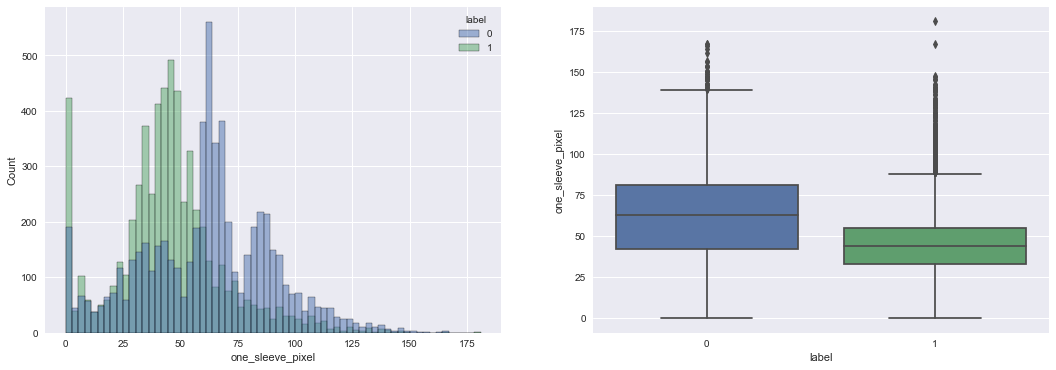

In [ ]:
# examine the distribution of one-sleeve total dark pixels
fig, ax = plt.subplots(1, 2, figsize=(18, 6))
sns.histplot(data = sleeve_analysis, x = "one_sleeve_pixel", hue="label", ax = ax[0])
sns.boxplot(data = sleeve_analysis, x ='label', y="one_sleeve_pixel", ax=ax[1])
plt.show()

The distribution of total number of black pixels around the sleeve area of non tshirt items is slightly to the right of that of tshirt items, which can be explained by the fact that lots of these items, as visualized, are long-sleeved shirts/dresses. This fact can help the model better distinguish between tshirts and other items. We start fitting the model by creating some similar functions to the models to the num_spots sections, but applying for the sleeve_pixel feature.

In [18]:
def standardize_sleeve_spots(df):
    """
    Use min-max scaler technique to scale the one_sleeve_pixel column in the df to the range [0,1]
    
    Args:
    ----
    df: The dataframe to be modified
    
    Return:
    ----
    The modified dataframe
    
    """
    df['one_sleeve_pixel'] = (df['one_sleeve_pixel'] - min(df['one_sleeve_pixel']))/(max(df['one_sleeve_pixel']) - min(df['one_sleeve_pixel']))
    return df

def boxcox_trans_sleeve(df):
    """
    Use boxcox transformation technique to scale the one_sleeve_pixel column in the df to the range [0,1]
    
    Args:
    ----
    df: The dataframe to be modified
    
    Return:
    ----
    The modified dataframe
    
    """
    df['one_sleeve_pixel'] = boxcox(df['one_sleeve_pixel'], 0.3)
    return df

In [ ]:
def sleeve_pixels_lrcv(x_df, y_df, standardized=True, boxcox=False):
    """
    Preprocess the added feature, total number of dark spots around the sleeve area, and fit Logistic Regression 
    CV model on the dataset
    
    Args
    ----
    x_df: The full dataset to work on, this set is going to be split into testing and training sets
    y_df: The labels corresponding to x_df
    standardized: Whether the num_spots column has already been standardized or not, default ot True
    boxcox: Whether x_df is a boxcox-transformed dataframe or not, default to False
    
    Return
    ----
    None. The metrics (AUC and accuracy) will be printed out.
    
    """
    if standardized == False:
        if boxcox == False:
            x_df2 = standardize_sleeve_spots(x_df)
            
        else:
            x_df2 = boxcox_trans_sleeve(x_df)
    else:
        x_df2 = x_df.copy()
    x_train, x_test, y_train, y_test = train_test_split(x_df2, y_df, test_size=0.15, random_state=42)
    lrcv = LogisticRegressionCV(cv=4, max_iter=500)
    lrcv.fit(x_train, y_train)
    calc_metrics(lrcv, x_train, y_train, x_test, y_test)

The order of combinations we are going to fit is:
- Original data with one_sleeve_pixel feature
- Boxcox-transformed data with one_sleeve_pixel feature
- Original data with one_sleeve_pixel feature and num_spots
- Boxcox-transformed data with one_sleeve_pixel feature and num_spots
- Augmented (2X) boxcox dataset with num_spots and one_sleeve_pixel features

### Original data with one_sleeve_pixel feature

In [ ]:
sleeve_pixels_lrcv(original, train_shirt_y, standardized=False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9433032803272637
The testing AUC score is 0.9381620553359684

The training accuracy is: 0.870686274509804
The testing accuracy is: 0.86


In [ ]:
original = train_shirt_x.copy()
original['one_sleeve_pixel'] = sleeve_analysis['one_sleeve_pixel']

### Boxcox-transformed data with one_sleeve_pixel feature

In [ ]:
fe3 = boxcox_df.copy()
fe3['one_sleeve_pixel'] = sleeve_analysis['one_sleeve_pixel']
sleeve_pixels_lrcv(fe3, train_shirt_y, standardized=False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9483774068036418
The testing AUC score is 0.9435350790513832

The training accuracy is: 0.8723529411764706
The testing accuracy is: 0.8683333333333333


### Original data with one_sleeve_pixel feature and num_spots

In [ ]:
original_num_spot = train_shirt_x.copy()
original_num_spot['num_spots'] = num_spots
original_num_spot = standardize_num_spot(original_num_spot)
original_num_spot.head(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots
0,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0041,0.0000,...,0.3320,0.0000,0.0,0.004,0.0000,0.0000,0.0,0.0,0.0,0.377609
1,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0106,0.0046,0.0000,0.0000,...,0.3589,0.3577,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.478178
2,0.0,0.0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0,0.000,0.0000,0.0000,0.0,0.0,0.0,0.609108
3,0.0,0.0,0.0,0.0,0.0000,0.0043,0.0000,0.0000,0.0041,0.0042,...,0.0000,0.0000,0.0,0.224,0.6392,0.5909,0.0,0.0,0.0,0.557875
4,0.0,0.0,0.0,0.0,0.0051,0.0049,0.0000,0.0000,0.0000,0.0039,...,0.1290,0.0285,0.0,0.000,0.0045,0.0000,0.0,0.0,0.0,0.673624


In [ ]:
original_num_spot['one_sleeve_pixel'] = sleeve_analysis['one_sleeve_pixel']
sleeve_pixels_lrcv(original_num_spot, train_shirt_y, standardized=False)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9433787909079724
The testing AUC score is 0.9382065217391306

The training accuracy is: 0.8708823529411764
The testing accuracy is: 0.86


### Boxcox-transformed data with one_sleeve_pixel feature and num_spots

In [14]:
fe3_num_spot = boxcox_trans(fe1).copy()

In [15]:
fe3_num_spot.drop('is_tshirt', axis=1, inplace=True)
fe3_num_spot.head()

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,pixel010,pixel011,pixel012,pixel013,pixel014,pixel015,pixel016,pixel017,pixel018,pixel019,pixel020,pixel021,pixel022,pixel023,pixel024,pixel025,pixel026,pixel027,pixel028,pixel029,pixel030,pixel031,pixel032,pixel033,pixel034,pixel035,pixel036,pixel037,pixel038,pixel039,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots
0,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.692546,-3.333333,-3.333333,-3.333333,-1.652755,-0.315860,-0.808573,-0.597579,-1.091075,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.702088,-3.333333,-3.333333,-1.480531,-0.910842,...,-1.121310,-0.542893,-0.272075,-2.251403,-3.333333,-2.556179,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.702088,-3.333333,-3.333333,-1.111984,-0.878293,-0.880950,-0.878293,-0.548813,-0.638895,-0.757399,-0.787740,-0.904753,-0.938804,-3.333333,-3.333333,-2.697275,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,16.735212
1,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.481273,-2.670039,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.397305,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.702088,-2.702088,-3.333333,-3.333333,-3.333333,-1.062007,-0.530991,-0.224988,...,-0.188643,-0.305932,-0.291244,-0.434903,-3.333333,-3.333333,-2.702088,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.431676,-3.333333,-1.110438,-0.801141,-0.953624,-0.912950,-0.935995,-0.935995,-0.952966,-0.952966,-0.932978,-0.944663,-0.988008,-0.882178,-0.884640,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,17.504017
2,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.374709,-2.035491,-1.450401,-0.496267,-0.708319,-0.677148,-0.235506,-0.754483,-3.333333,-2.291808,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.702088,-3.333333,-3.333333,-3.333333,...,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-1.385914,-0.757399,-1.062987,-1.084790,-1.111211,-1.110438,-1.300954,-1.172397,-1.186247,-1.480531,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,18.415149
3,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.683324,-3.333333,-3.333333,-2.692546,-2.687897,-3.333333,-3.333333,-0.750124,-0.224988,-0.320789,-0.179623,-1.252811,-3.333333,-2.423313,-2.538708,-2.692546,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.702088,-2.702088,-2.374709,-2.556179,-3.333333,-3.333333,-3.333333,-3.333333,...,-0.170776,-0.179623,-0.701529,-3.333333,-3.333333,-0.622581,-0.093203,-0.296204,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-0.390928,-0.198416,-0.886284,-3.333333,-3.333333,-3.333333,-1.767962,-1.091075,-0.831376,-0.674603,-0.722199,-0.778586,-0.854675,-1.136796,-2.550254,-3.333333,-3.333333,-3.333333,-1.205424,-0.418795,-0.486691,-3.333333,-3.333333,-3.333333,18.069352
4,-3.333333,-3.333333,-3.333333,-3.333333,-2.64918

In [ ]:
fe3_num_spot['one_sleeve_pixel'] = sleeve_analysis['one_sleeve_pixel']
sleeve_pixels_lrcv(fe3_num_spot, train_shirt_y, standardized=False, boxcox=True)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9487012487696851
The testing AUC score is 0.943985918972332

The training accuracy is: 0.8723529411764706
The testing accuracy is: 0.8722222222222222


### Augmented (2X) boxcox dataset with num_spots and one_sleeve_pixel features

In [ ]:
augmented = data2X_standard.copy()
augmented['num_spots'] = num_spots
augmented = standardize_num_spot(augmented)

In [ ]:
augmented['one_sleeve_pixel'] = sleeve_analysis['one_sleeve_pixel']
augmented = boxcox_trans_sleeve(augmented)

In [ ]:
augmented2 = pd.concat([augmented, fe3_num_spot], axis=0).reset_index(drop=True)
augmented2.head(5)

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,...,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots,one_sleeve_pixel
0,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,...,-2.702088,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,0.377609,2.886887
1,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.397305,-3.333333,-3.333333,-3.333333,-3.333333,...,-3.333333,-2.431676,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,0.478178,6.968613
2,-3.333333,-3.333333,-3.333333,-2.291808,-3.333333,-0.754483,-0.235506,-0.677148,-0.708319,-0.496267,...,-1.111211,-1.084790,-1.062987,-0.757399,-1.385914,-3.333333,-3.333333,-3.333333,0.609108,10.209012
3,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.692546,-2.538708,-2.423313,...,-3.333333,-0.886284,-0.198416,-0.390928,-3.333333,-3.333333,-3.333333,-3.333333,0.557875,8.590288
4,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-1.288669,-0.757399,...,-1.544904,-3.333333,-3.333333,-2.649186,-3.333333,-3.333333,-3.333333,-3.333333,0.673624,8.328122


In [ ]:
sleeve_pixels_lrcv(augmented2, label2X)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-reg

The training AUC score is 0.9430066963420644
The testing AUC score is 0.9392506276067921

The training accuracy is: 0.8639705882352942
The testing accuracy is: 0.86


**DISCUSS AND COMPARE RESULTS OF FEATURE ENGINEERING TECHNIQUES:** 

So far, the models from this feature engineering section that perform best are:

1) The model with box-cox transformed data, with no features added, and the model with boxcox-transformed data and one_sleeve_pixel feature, both of which have training accuracy of 0.87245, and testing accuracy of 0.868333. We will go with the former model in the next section because it's simpler, yet have the same accuracy as the latter one.

2) The model using boxcox-transformed data with one_sleeve_pixel feature and num_spots, having training accuracy is: 0.872352, and testing accuracy is: 0.87222

These models don't significantly outperform the baseline model, however. The feature engineering techniques we applied, all the added features don't have much impact on this dataset, and some even hurt the performance. This might also be due to certain inherent limitations of Logistic Regression in dealing with image data (compared to other more complex methods like neural network) as discussed earlier at the end of section 2.3. The best performing models chosen above, both fitting the model on box-cox transformed data, have slightly better performance for both training and testing sets, and the gap between the training and true accuracy is also closer. We will now go on to tune some parameters of these models and compare to see if we can further improve the current performance.

## 3. Parameters tuning

We will tune the parameters of 2 models chosen above. Apart from accuracy, we will also try to find the model that minimizes the log loss, since a lower log loss means the model will make more accurate predictions on unseen data.

In [20]:
# train and test sets of the model with 2 features added
feat_x_train, feat_x_test, feat_y_train, feat_y_test = train_test_split(fe3_num_spot, train_shirt_y, test_size=0.15, random_state=42)

# train and test sets of the model with no features added
none_x_train, none_x_test, none_y_train, none_y_test = train_test_split(boxcox_df, train_shirt_y, test_size=0.15, random_state=42)


In [21]:
# reset the index from randomization
feat_x_train = feat_x_train.reset_index(drop=True)
feat_x_test = feat_x_test.reset_index(drop=True)
none_x_train = none_x_train.reset_index(drop=True)
none_x_test = none_x_test.reset_index(drop=True)

feat_y_train = feat_y_train.reset_index(drop=True)
feat_y_test = feat_y_test.reset_index(drop=True)
none_y_train = none_y_train.reset_index(drop=True)
none_y_test = none_y_test.reset_index(drop=True)

**RandomizedSearchCV**

Random search is a technique where random combinations of the hyperparameters are used to find the best solution for the built model. It tries random combinations of a range of values. This is less exhaustive than Grid search, yet it's proved to yield comparatively good combination of parameters. Using Randomized Grid Search, we can narrow down the serach area for the best model. We are going to try 3 regularization methods: l1, l2, and elasticnet (a combination of l1 and l2). Each regularization method has a different set of compatible solvers. For each model-regularization combination, we are going to find the best C value, then tune the model to find the most optimal max iterations. The randomized grid search for these models are:

In [ ]:
# Randomized Search Cross Validation for l2

# C
C_l2 = [float(x) for x in np.logspace(-9, 4, 30)]
# penalty
regularization_l2 = ['l2']
# solver 
solver_l2 = ['newton-cg', 'lbfgs', 'sag']
# Create the random grid
random_grid_l2 = {'C': C_l2,'penalty': regularization_l2,'solver': solver_l2}

print(random_grid_l2)

{'C': [1e-09, 2.8072162039411812e-09, 7.880462815669905e-09, 2.2122162910704503e-08, 6.210169418915617e-08, 1.7433288221999873e-07, 4.893900918477499e-07, 1.3738237958832638e-06, 3.856620421163472e-06, 1.082636733874054e-05, 3.039195382313195e-05, 8.531678524172815e-05, 0.0002395026619987486, 0.0006723357536499335, 0.0018873918221350996, 0.005298316906283713, 0.014873521072935119, 0.041753189365604, 0.11721022975334794, 0.3290344562312671, 0.9236708571873846, 2.592943797404667, 7.278953843983161, 20.433597178569396, 57.361525104486816, 161.02620275609425, 452.03536563602404, 1268.9610031679233, 3562.2478902624516, 10000.0], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'sag']}


In [30]:
# Randomized Search Cross Validation for l1

# C
C_l1 = [float(x) for x in np.logspace(-9, 4, 30)]
# penalty
regularization_l1 = ['l1']
# solver 
solver_l1 = ['liblinear', 'saga']
# Create the random grid
random_grid_l1 = {'C': C_l1,'penalty': regularization_l1,'solver': solver_l1}

print(random_grid_l1)

{'C': [1e-09, 2.8072162039411812e-09, 7.880462815669905e-09, 2.2122162910704503e-08, 6.210169418915617e-08, 1.7433288221999873e-07, 4.893900918477499e-07, 1.3738237958832638e-06, 3.856620421163472e-06, 1.082636733874054e-05, 3.039195382313195e-05, 8.531678524172815e-05, 0.0002395026619987486, 0.0006723357536499335, 0.0018873918221350996, 0.005298316906283713, 0.014873521072935119, 0.041753189365604, 0.11721022975334794, 0.3290344562312671, 0.9236708571873846, 2.592943797404667, 7.278953843983161, 20.433597178569396, 57.361525104486816, 161.02620275609425, 452.03536563602404, 1268.9610031679233, 3562.2478902624516, 10000.0], 'penalty': ['l1'], 'solver': ['liblinear', 'saga']}


In [31]:
# Randomized Search Cross Validation for elasticnet

# C
C_en = [float(x) for x in np.logspace(-9, 4, 30)]
# penalty
regularization_en = ['elasticnet']
# solver 
solver_en = ['saga']
# l1_ratio
l1_ratio = [float(x) for x in np.linspace(0.1, 0.9, 9)]
# Create the random grid
random_grid_en = {'C': C_en,'penalty': regularization_en,'solver': solver_en, 'l1_ratio': l1_ratio}

print(random_grid_en)

{'C': [1e-09, 2.8072162039411812e-09, 7.880462815669905e-09, 2.2122162910704503e-08, 6.210169418915617e-08, 1.7433288221999873e-07, 4.893900918477499e-07, 1.3738237958832638e-06, 3.856620421163472e-06, 1.082636733874054e-05, 3.039195382313195e-05, 8.531678524172815e-05, 0.0002395026619987486, 0.0006723357536499335, 0.0018873918221350996, 0.005298316906283713, 0.014873521072935119, 0.041753189365604, 0.11721022975334794, 0.3290344562312671, 0.9236708571873846, 2.592943797404667, 7.278953843983161, 20.433597178569396, 57.361525104486816, 161.02620275609425, 452.03536563602404, 1268.9610031679233, 3562.2478902624516, 10000.0], 'penalty': ['elasticnet'], 'solver': ['saga'], 'l1_ratio': [0.1, 0.2, 0.30000000000000004, 0.4, 0.5, 0.6, 0.7000000000000001, 0.8, 0.9]}


Define some functions to fit models conveniently

In [22]:
def best_C(C_range, x_train, x_test, y_train, y_test, solver, penalty, elasticnet=False, l1_ratio=0.0):
  """
  Fit logistic regression models on a range of C values

  Args:
  ----
  C_range: an array/list of C values to examine
  x_train, x_test, y_train, y_test: the split training and testing sets to fit and evaluate the models on
  solver: the solver used for fitting logistic regression model, a string
  penalty: the penalty type used for fitting logistic regression model, a string
  elasticnet: whether this logistic regression model is fitted with 'elasticnet' regularization method or not, 
        a boolean. Default to False
  l1_ratio: if elasticnet is True, must be provided for fitting the model, a float between 0.1 and 0.9

  Return:
  ----
  4 lists of the training/testing accuracy and log loss scores across all C values

  """  
    train_logLoss = []
    train_accuracy = []
    test_logLoss = []
    test_accuracy = []
    for C in C_range:
        if elasticnet == False:
            lm_mod = LogisticRegression(C = C, solver = solver, penalty=penalty)
        else :
            lm_mod = LogisticRegression(C = C, solver = solver, penalty=penalty, l1_ratio = l1_ratio)
        lm_mod.fit(x_train, y_train)

        train_y_prob= lm_mod.predict_proba(x_train)
        test_y_prob = lm_mod.predict_proba(x_test)

        train_logLoss.append(log_loss(y_train, train_y_prob))
        train_accuracy.append(lm_mod.score(x_train, y_train))
        test_logLoss.append(log_loss(y_test, test_y_prob))
        test_accuracy.append(lm_mod.score(x_test, y_test))
    return train_logLoss, train_accuracy, test_logLoss, test_accuracy

In [23]:
def visualize_C(C_range, train_logLoss, train_accuracy, test_logLoss, test_accuracy):
  """
  Plot the C values vs accuracy and log loss

  Args:
  ----
  C_range: The range of C values the model is fitted on
  train_logLoss, test_logLoss: the train and test log loss output from the model fitted
  train_accuracy, test_accuracy: the train and test accuracy scores output from the model fitted

  Return:
  ----
  None. The metrics are plotted side by side

  """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    ax[0].plot(C_range, train_accuracy, color="blue", label="Train")
    ax[0].plot(C_range, test_accuracy, color="red", label="Test")
    ax[1].plot(C_range, train_logLoss, color="blue", label="Train")
    ax[1].plot(C_range, test_logLoss, color="red", label="Test")
    ax[0].title.set_text("Accuracy by C values")
    ax[0].set_xlabel("C values")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(frameon=True, framealpha=1,facecolor='white')
    ax[1].title.set_text("Log loss by C values")
    ax[1].set_xlabel("C values")
    ax[1].set_ylabel("Log loss")
    ax[1].legend(frameon=True, framealpha=1,facecolor='white')
    plt.xscale('log') # log scale for C values
    plt.show()

In [24]:
def make_table(C_range, train_logLoss, train_accuracy, test_logLoss, test_accuracy):
  """
  Print scores output from the logistic regression models as a table

  Args:
  ----
  C_range: The range of C values the model is fitted on
  train_logLoss, test_logLoss: the train and test log loss output from the model fitted
  train_accuracy, test_accuracy: the train and test accuracy scores output from the model fitted

  Return:
  ----
  None. The full table is printed to the screen.

  """
    table_of_values = pd.DataFrame(columns=['C_values', 'train_accuracy', 'train_log_loss', 'test_accuracy', 
                                            'test_log_loss'])
    table_of_values['C_values'] = C_range
    table_of_values['train_accuracy'] = train_accuracy
    table_of_values['train_log_loss'] = train_logLoss
    table_of_values['test_accuracy'] = test_accuracy
    table_of_values['test_log_loss'] = test_logLoss
    print(table_of_values)

In [45]:
def best_iter(iter_range, bestC, x_train, x_test, y_train, y_test, solver, penalty, elasticnet=False, l1_ratio=0.0):
  """
  Fit logistic regression models on a range of max iterations

  Args:
  ----
  iter_range: an array/list of max iteration values to examine
  bestC: the best C value chosen
  x_train, x_test, y_train, y_test: the split training and testing sets to fit and evaluate the models on
  solver: the solver used for fitting logistic regression model, a string
  penalty: the penalty type used for fitting logistic regression model, a string
  elasticnet: whether this logistic regression model is fitted with 'elasticnet' regularization method or not, 
        a boolean. Default to False
  l1_ratio: if elasticnet is True, must be provided for fitting the model, a float between 0.1 and 0.9

  Return:
  ----
  4 lists of the training/testing accuracy and log loss scores across all max iteration values

  """  
    train_logLoss = []
    train_accuracy = []
    test_logLoss = []
    test_accuracy = []
    for i in iter_range:
        if elasticnet == False:
            lm_mod = LogisticRegression(C = bestC, solver = solver, penalty=penalty, max_iter=i)
        else :
            lm_mod = LogisticRegression(C = bestC, solver = solver, penalty=penalty, l1_ratio = l1_ratio, max_iter=i)
        lm_mod.fit(x_train, y_train)

        train_y_prob= lm_mod.predict_proba(x_train)
        test_y_prob = lm_mod.predict_proba(x_test)

        train_logLoss.append(log_loss(y_train, train_y_prob))
        train_accuracy.append(lm_mod.score(x_train, y_train))
        test_logLoss.append(log_loss(y_test, test_y_prob))
        test_accuracy.append(lm_mod.score(x_test, y_test))
    return train_logLoss, train_accuracy, test_logLoss, test_accuracy

In [26]:
def visualize_iter(iter_range, train_logLoss, train_accuracy, test_logLoss, test_accuracy):
  """
  Plot the max iterations vs accuracy and log loss

  Args:
  ----
  iter_range: The range of max iterations the model is fitted on
  train_logLoss, test_logLoss: the train and test log loss output from the model fitted
  train_accuracy, test_accuracy: the train and test accuracy scores output from the model fitted

  Return:
  ----
  None. The metrics are plotted side by side

  """
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharex=True)
    ax[0].plot(iter_range, train_accuracy, color="blue", label="Train")
    ax[0].plot(iter_range, test_accuracy, color="red", label="Test")
    ax[1].plot(iter_range, train_logLoss, color="blue", label="Train")
    ax[1].plot(iter_range, test_logLoss, color="red", label="Test")
    ax[0].title.set_text("Accuracy by max iterations")
    ax[0].set_xlabel("Max iterations")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend(frameon=True, framealpha=1,facecolor='white')
    ax[1].title.set_text("Log loss by max iterations")
    ax[1].set_xlabel("Max iterations")
    ax[1].set_ylabel("Log loss")
    ax[1].legend(frameon=True, framealpha=1,facecolor='white')
    plt.show()

### Model 1: No feature added model

#### A. L2 regularization

In [ ]:
# define the random search
lrc_none_l2 = LogisticRegression(random_state=8)
random_search_none_l2 = RandomizedSearchCV(estimator=lrc_none_l2,
                                   param_distributions=random_grid_l2,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model 
random_search_none_l2.fit(none_x_train, none_y_train)

In [ ]:
# examine the best results
print("The best hyperparameters from Random Search are:")
print(random_search_none_l2.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_none_l2.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'C': 0.0018873918221350996}

The mean accuracy of a model with these hyperparameters is:
0.8553921568627452


In [ ]:
# search in detail the area around the best C values
C_range_none_l2 = np.logspace(-4, 0, 20)
train_logLoss_none_l2, train_accuracy_none_l2, test_logLoss_none_l2, test_accuracy_none_l2 =  best_C(
    C_range_none_l2, none_x_train, none_x_test, none_y_train,none_y_test, 'sag', 'l2')

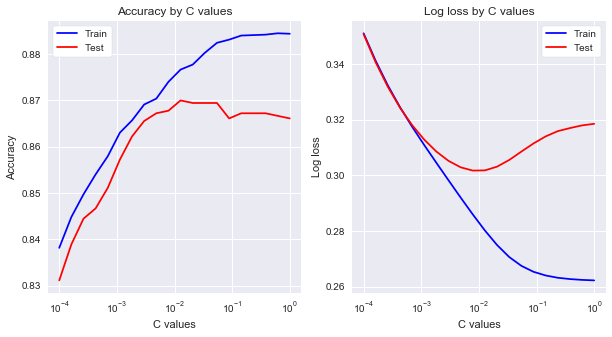

In [ ]:
# visualize the results
visualize_C(C_range_none_l2, train_logLoss_none_l2, train_accuracy_none_l2, test_logLoss_none_l2, 
            test_accuracy_none_l2)

In [ ]:
make_table(C_range_none_l2, train_logLoss_none_l2, train_accuracy_none_l2, test_logLoss_none_l2, 
           test_accuracy_none_l2)

    C_values  train_accuracy  train_log_loss  test_accuracy  test_log_loss
0   0.000100        0.838137        0.351050       0.831111       0.350753
1   0.000162        0.844804        0.341114       0.838889       0.340576
2   0.000264        0.849706        0.332309       0.844444       0.331783
3   0.000428        0.854020        0.324504       0.846667       0.324304
4   0.000695        0.857941        0.317451       0.851111       0.318031
5   0.001129        0.863039        0.310857       0.857222       0.312808
6   0.001833        0.865686        0.304480       0.862222       0.308526
7   0.002976        0.869118        0.298194       0.865556       0.305186
8   0.004833        0.870392        0.291985       0.867222       0.302871
9   0.007848        0.874020        0.285924       0.867778       0.301700
10  0.012743        0.876667        0.280147       0.870000       0.301771
11  0.020691        0.877745        0.274930       0.869444       0.303115
12  0.033598        0.880

**DISCUSS:** From the graph and the table of results, we can see that the best value is around the 11th C values, where the test log loss is around its most optimal point, the testing accuracy is the highest, and just right before the model takes a turn for the worse and overfits the data. It is also important to note that when visualized on a larger range of C values (from 10^-9 to 10^6), the log loss on test data reaches a plateau from C value of around 10^1 and beyond. Therefore, this smaller range of C values we are examining already captured the optimized log loss (min log loss) and the best test accuracy. The testing accuracy has increased by almost 1% from the baseline model. Next, we are going to examine the max iteration parameter

In [ ]:
# tune max_iter parameter
best_C_none_l2 = C_range_none_l2[10] # best C value
maxiter_none_l2 = np.linspace(10, 300, 30)

iter_train_logLoss_none_l2, iter_train_accuracy_none_l2, iter_test_logLoss_none_l2, iter_test_accuracy_none_l2 = best_iter(
    maxiter_none_l2, best_C_none_l2, none_x_train, none_x_test, none_y_train,none_y_test, 'sag', 'l2')

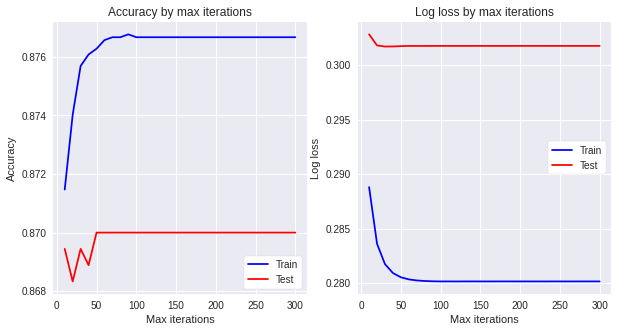

In [48]:
visualize_iter(maxiter_none_l2, iter_train_logLoss_none_l2, iter_train_accuracy_none_l2, iter_test_logLoss_none_l2, iter_test_accuracy_none_l2)

**DISCUSS:** The accuracy increases as we increase the max iterations up until around 50, and the log loss decreases. After this value, the train, test accuracy and log loss reaches a plateau. We achieve similar results from the previous analysis since initially the default value for max_iter is 100, and we already reached the optimal point within 50 iterations. This is a good max_iter value because it's not too high, so running it won't be too computationally expensive. The gap between training and testing accuracy also widens as we increase max_iter, which shows that the model starts to overfit as max_iter increases. However, this difference in both accuracy scores is not substantial (0.006 point), so in fact, the model performs well on training and testing data

#### B. L1 regularization

In [ ]:
# define the random search
lrc_none_l1 = LogisticRegression(random_state=8)
random_search_none_l1 = RandomizedSearchCV(estimator=lrc_none_l1,
                                   param_distributions=random_grid_none_l1,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model 
random_search_none_l1.fit(none_x_train, none_y_train)

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search_none_l1.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_none_l1.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'l1', 'C': 0.11721022975334794}

The mean accuracy of a model with these hyperparameters is:
0.8546078431372549


In [ ]:
# search in detail the area around the best C values
C_range_none_l1 = np.logspace(-2, 4, 20)
train_logLoss_none_l1, train_accuracy_none_l1, test_logLoss_none_l1, test_accuracy_none_l1 =  best_C(
    C_range_none_l1, none_x_train, none_x_test, none_y_train,none_y_test, 'saga', 'l1')

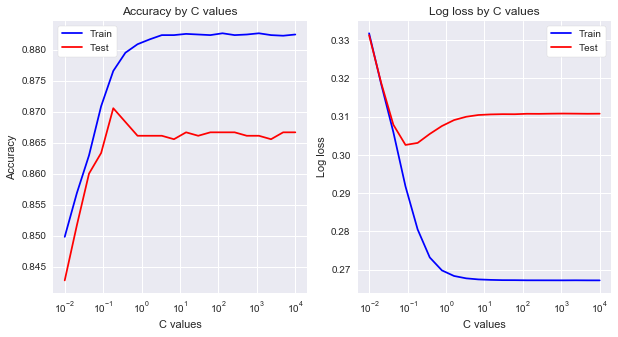

In [ ]:
# visualize the results
visualize_C(C_range_none_l1, train_logLoss_none_l1, train_accuracy_none_l1, test_logLoss_none_l1, 
            test_accuracy_none_l1)

In [ ]:
make_table(C_range_none_l1, train_logLoss_none_l1, train_accuracy_none_l1, test_logLoss_none_l1, 
           test_accuracy_none_l1)

        C_values  train_accuracy  train_log_loss  test_accuracy  test_log_loss
0       0.010000        0.849804        0.331769       0.842778       0.331271
1       0.020691        0.856863        0.318433       0.851667       0.318766
2       0.042813        0.862941        0.305908       0.860000       0.307855
3       0.088587        0.870882        0.291720       0.863333       0.302577
4       0.183298        0.876569        0.280489       0.870556       0.303104
5       0.379269        0.879510        0.273157       0.868333       0.305455
6       0.784760        0.880882        0.269774       0.866111       0.307520
7       1.623777        0.881667        0.268315       0.866111       0.309076
8       3.359818        0.882353        0.267695       0.866111       0.309943
9       6.951928        0.882353        0.267418       0.865556       0.310402
10     14.384499        0.882549        0.267296       0.866667       0.310556
11     29.763514        0.882451        0.267226    

**DISCUSS:** The performance of this model is as good as the one with l2 regularization, and the most optimal C value is also close to that of the previous model. The shape of accuarcy and log loss is also similar. We examine the max iteration parameter to see if it results in any difference from the previous model

In [ ]:
# tune max_iter parameter
best_C_none_l1 = C_range_none_l1[4] # best C value
maxiter_none_l1 = np.linspace(10, 300, 30)

iter_train_logLoss_none_l1, iter_train_accuracy_none_l1, iter_test_logLoss_none_l1, iter_test_accuracy_none_l1 = best_iter(
    maxiter_none_l1, best_C_none_l1, none_x_train, none_x_test, none_y_train,none_y_test, 'saga', 'l1')

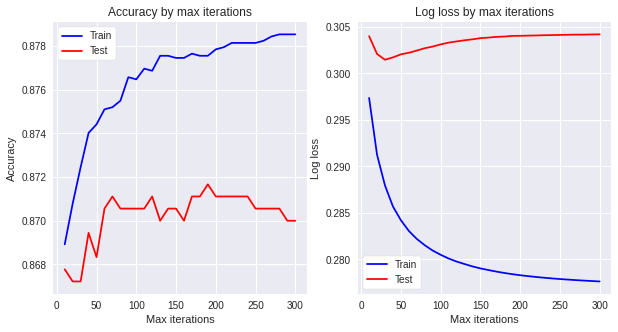

In [57]:
visualize_iter(maxiter_none_l1, iter_train_logLoss_none_l1, iter_train_accuracy_none_l1, iter_test_logLoss_none_l1, iter_test_accuracy_none_l1)

**DISCUSS:** The model with l1 regularization saw a rise in performance as we increase the max iterations up to a certain point, with a lot of fluctuations compared to l2 model. It also shows signs of overfitting after max_iter of 50, though the gap between testing and training accuracy is narrower than that of l2 model. The peak performance of this model is achieved with around 150-200, and at around max_iter of 60, the testing accuracy is slightly higher. So given that the results are not much better, one may go for l2 model as it achieves as good results, yet requires few iterations.

#### C. Elastic net

In [ ]:
# define the random search
lrc_none_en = LogisticRegression(random_state=8)
random_search_none_en = RandomizedSearchCV(estimator=lrc_none_en,
                                   param_distributions=random_grid_en,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model 
random_search_none_en.fit(none_x_train, none_y_train)

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search_none_en.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_none_en.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.30000000000000004, 'C': 0.014873521072935119}

The mean accuracy of a model with these hyperparameters is:
0.8536274509803922


In [ ]:
# using the same idea as above, we choose the best C value and search in detail the area around this value
C_range_none_en = np.logspace(-3, 2, 20)
train_logLoss_none_en, train_accuracy_none_en, test_logLoss_none_en, test_accuracy_none_en =  best_C(
    C_range_none_en, none_x_train, none_x_test, none_y_train,none_y_test, 'saga', 'elasticnet', elasticnet=True,l1_ratio=0.3)

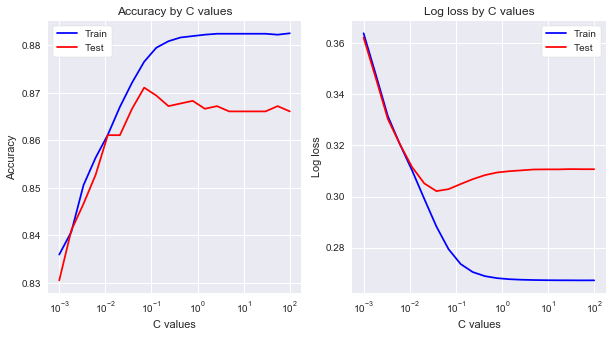

In [ ]:
# visualize the results
visualize_C(C_range_none_en, train_logLoss_none_en, train_accuracy_none_en, test_logLoss_none_en, 
            test_accuracy_none_en)

In [ ]:
make_table(C_range_none_en, train_logLoss_none_en, train_accuracy_none_en, test_logLoss_none_en, 
           test_accuracy_none_en)

      C_values  train_accuracy  train_log_loss  test_accuracy  test_log_loss
0     0.001000        0.835980        0.363920       0.830556       0.362244
1     0.001833        0.840784        0.347886       0.841111       0.346479
2     0.003360        0.850588        0.331478       0.846667       0.330326
3     0.006158        0.856373        0.320388       0.852778       0.320414
4     0.011288        0.861176        0.310178       0.861111       0.311513
5     0.020691        0.867059        0.299101       0.861111       0.305150
6     0.037927        0.872157        0.288276       0.866667       0.302130
7     0.069519        0.876569        0.279407       0.871111       0.302898
8     0.127427        0.879510        0.273564       0.869444       0.304896
9     0.233572        0.880882        0.270423       0.867222       0.306806
10    0.428133        0.881667        0.268838       0.867778       0.308388
11    0.784760        0.881961        0.268048       0.868333       0.309422

In [ ]:
# tune max_iter parameter
best_C_none_en = C_range_none_en[7] # using the same idea as before, we choose the best C value
maxiter_none_en = np.linspace(10, 300, 30)

iter_train_logLoss_none_en, iter_train_accuracy_none_en, iter_test_logLoss_none_en, iter_test_accuracy_none_en = best_iter(
    maxiter_none_en, best_C_none_en, none_x_train, none_x_test, none_y_train,none_y_test, 'saga', 'elasticnet', elasticnet=True, l1_ratio=0.3)


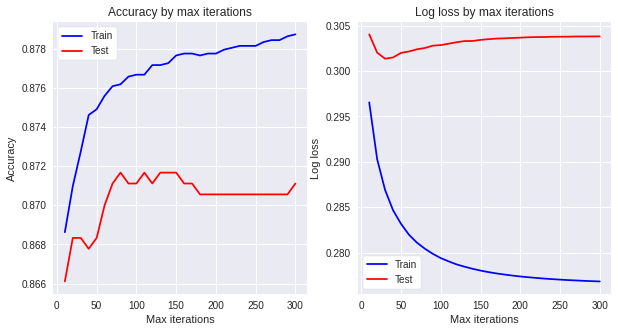

In [55]:
visualize_iter(maxiter_none_en, iter_train_logLoss_none_en, iter_train_accuracy_none_en, iter_test_logLoss_none_en, iter_test_accuracy_none_en)


**DISCUSS:** Like l1 model, elasticnet is only slightly better than l2 model. We also achieve equally good accuracy and log loss. The C value for this model, however, is 0.06, which is slightly higher than those of the previous models. As we increase max iterations, the model also shows signs of overfitting, like l2 and l1 model. However, the gap between the training and testing accuracy is narrower than l2 model up to around max_iter of 150. The testing log loss from max_iter of 50 onwards is mostly flat, and not differ much from the optimal point. The best result for this model is max_iter in the range 70-80, where we get the best testing accuracy. It's also worth noting that elasticnet model achieves equally good result as l1 model at max_iter of 150, but with only ~70 iterations. One can choose elasticnet over l2 model for this reason (yield better results with only a few more iterations)

### Model 2: Model with num_spots and sleeve_pixels

#### A. L2 regularization

In [ ]:
# define the random search
lrc_feat_l2 = LogisticRegression(random_state=8)
random_search_feat_l2 = RandomizedSearchCV(estimator=lrc_feat_l2,
                                   param_distributions=random_grid_l2,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model 
random_search_feat_l2.fit(feat_x_train, feat_y_train)

In [ ]:
print("The best hyperparameters from Random Search are:")
print(random_search_feat_l2.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_feat_l2.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'sag', 'penalty': 'l2', 'C': 0.005298316906283713}

The mean accuracy of a model with these hyperparameters is:
0.8559803921568627


In [ ]:
# search in detail the area around the best C values
C_range_feat_l2 = np.logspace(-3, 2, 20)
train_logLoss_feat_l2, train_accuracy_feat_l2, test_logLoss_feat_l2, test_accuracy_feat_l2 =  best_C(
    C_range_feat_l2, feat_x_train, feat_x_test, feat_y_train,feat_y_test, 'sag', 'l2')

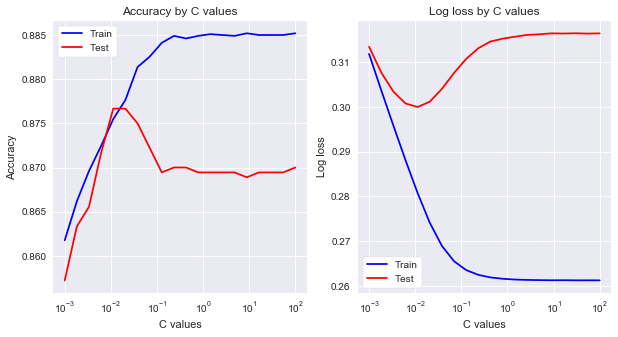

In [ ]:
# visualize the results
visualize_C(C_range_feat_l2, train_logLoss_feat_l2, train_accuracy_feat_l2, test_logLoss_feat_l2, 
            test_accuracy_feat_l2)

In [ ]:
make_table(C_range_feat_l2, train_logLoss_feat_l2, train_accuracy_feat_l2, test_logLoss_feat_l2, 
           test_accuracy_feat_l2)

      C_values  train_accuracy  train_log_loss  test_accuracy  test_log_loss
0     0.001000        0.861765        0.311833       0.857222       0.313431
1     0.001833        0.866176        0.303730       0.863333       0.307698
2     0.003360        0.869608        0.295835       0.865556       0.303422
3     0.006158        0.872451        0.288114       0.871667       0.300768
4     0.011288        0.875490        0.280739       0.876667       0.299971
5     0.020691        0.877647        0.274129       0.876667       0.301160
6     0.037927        0.881373        0.268952       0.875000       0.304026
7     0.069519        0.882549        0.265523       0.872222       0.307590
8     0.127427        0.884118        0.263548       0.869444       0.310721
9     0.233572        0.884902        0.262488       0.870000       0.313103
10    0.428133        0.884608        0.261912       0.870000       0.314608
11    0.784760        0.884902        0.261612       0.869444       0.315234

**DISCUSS:** In the same way as the previous models, we will choose the C value that yields a good balance between accuracy and log loss, which in this is the C value at index 5, after which the training and testing accuracy diverges (overfitting), and before which the model underfits the data. The log loss at this point is also close to the optimal log loss.

In [ ]:
# tune max_iter parameter
best_C_feat_l2 = C_range_feat_l2[5] # best C value
maxiter_feat_l2 = np.linspace(10, 300, 30)

iter_train_logLoss_feat_l2, iter_train_accuracy_feat_l2, iter_test_logLoss_feat_l2, iter_test_accuracy_feat_l2 = best_iter(
    maxiter_feat_l2, best_C_feat_l2, feat_x_train, feat_x_test, feat_y_train,feat_y_test, 'sag', 'l2')

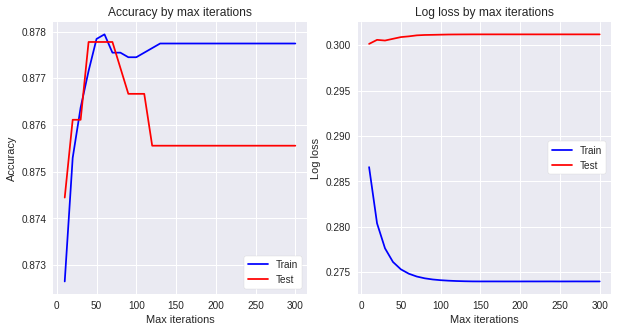

In [63]:
visualize_iter(maxiter_feat_l2, iter_train_logLoss_feat_l2, iter_train_accuracy_feat_l2, iter_test_logLoss_feat_l2, iter_test_accuracy_feat_l2)


**DISCUSS:** This model achieves similar, low log loss compared to previous models, but better testing accuracy. The model exhibits overfitting after max_iter of around 60, but at around max_iter of 50-60, the testing and training accuracy scores are very close to each other and are also the most optimal points of the model, making it ideal for the prediction of unseen data. This model is more preferable to previous models since it yields better results with as many iterations.

#### B. L1 regularization

In [ ]:
# define the random search
lrc_feat_l1 = LogisticRegression(random_state=8)
random_search_feat_l1 = RandomizedSearchCV(estimator=lrc_feat_l1,
                                   param_distributions=random_grid_l1,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model 
random_search_feat_l1.fit(feat_x_train, feat_y_train)

In [65]:
print("The best hyperparameters from Random Search are:")
print(random_search_feat_l1.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_feat_l1.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'l1', 'C': 0.11721022975334794}

The mean accuracy of a model with these hyperparameters is:
0.853235294117647


In [ ]:
# search in detail the area around the best C values
C_range_feat_l1 = np.logspace(-2, 2, 20)
train_logLoss_feat_l1, train_accuracy_feat_l1, test_logLoss_feat_l1, test_accuracy_feat_l1 =  best_C(
    C_range_feat_l1, feat_x_train, feat_x_test, feat_y_train,feat_y_test, 'saga', 'l1')

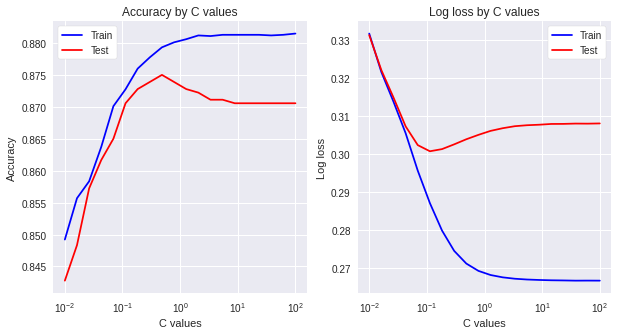

In [67]:
# visualize the results
visualize_C(C_range_feat_l1, train_logLoss_feat_l1, train_accuracy_feat_l1, test_logLoss_feat_l1, 
            test_accuracy_feat_l1)

In [68]:
make_table(C_range_feat_l1, train_logLoss_feat_l1, train_accuracy_feat_l1, test_logLoss_feat_l1, 
            test_accuracy_feat_l1)

      C_values  train_accuracy  train_log_loss  test_accuracy  test_log_loss
0     0.010000        0.849216        0.331616       0.842778       0.331197
1     0.016238        0.855686        0.321477       0.848333       0.321995
2     0.026367        0.858333        0.313686       0.857222       0.314787
3     0.042813        0.863725        0.305401       0.861667       0.307206
4     0.069519        0.870098        0.295545       0.865000       0.302266
5     0.112884        0.872745        0.287004       0.870556       0.300648
6     0.183298        0.875980        0.279782       0.872778       0.301216
7     0.297635        0.877745        0.274443       0.873889       0.302466
8     0.483293        0.879314        0.271107       0.875000       0.303806
9     0.784760        0.880098        0.269175       0.873889       0.304965
10    1.274275        0.880588        0.268090       0.872778       0.306009
11    2.069138        0.881176        0.267477       0.872222       0.306713

In [ ]:
# tune max_iter parameter
best_C_feat_l1 = C_range_feat_l1[8] # using the same idea as previous models to choose the best C value
maxiter_feat_l1 = np.linspace(10, 300, 30)

iter_train_logLoss_feat_l1, iter_train_accuracy_feat_l1, iter_test_logLoss_feat_l1, iter_test_accuracy_feat_l1 = best_iter(
    maxiter_feat_l1, best_C_feat_l1, feat_x_train, feat_x_test, feat_y_train,feat_y_test, 'saga', 'l1')

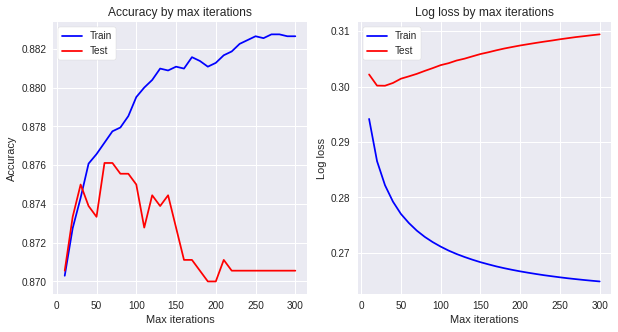

In [70]:
visualize_iter(maxiter_feat_l1, iter_train_logLoss_feat_l1, iter_train_accuracy_feat_l1, iter_test_logLoss_feat_l1, iter_test_accuracy_feat_l1)

**DISCUSS:** This model experiences overfitting quite early on. At max_iter of 50, it saw a drop in testing accuracy, before rising again to its peak performance point (with testing accuracy at ~0.876). The peak performance of this model is slightly lower than l2 penalty. The log loss is comparatively good, but compared to l2, it rises more sharply after reaching the optimal point. For such reasons, it's better to choose l2 over l1 model.


#### C. Elasticnet

In [ ]:
# define the random search
lrc_feat_en = LogisticRegression(random_state=8)
random_search_feat_en = RandomizedSearchCV(estimator=lrc_feat_en,
                                   param_distributions=random_grid_en,
                                   n_iter=50,
                                   scoring='accuracy',
                                   cv=3, 
                                   verbose=1, 
                                   random_state=8)

# Fit the random search model 
random_search_feat_en.fit(feat_x_train, feat_y_train)

In [36]:
print("The best hyperparameters from Random Search are:")
print(random_search_feat_en.best_params_)
print("")
print("The mean accuracy of a model with these hyperparameters is:")
print(random_search_feat_en.best_score_)

The best hyperparameters from Random Search are:
{'solver': 'saga', 'penalty': 'elasticnet', 'l1_ratio': 0.30000000000000004, 'C': 0.014873521072935119}

The mean accuracy of a model with these hyperparameters is:
0.8540196078431372


In [ ]:
# search in detail the area around the best C values
C_range_feat_en = np.logspace(-3, 1, 20)
train_logLoss_feat_en, train_accuracy_feat_en, test_logLoss_feat_en, test_accuracy_feat_en =  best_C(
    C_range_feat_en, feat_x_train, feat_x_test, feat_y_train,feat_y_test, 'saga', 'elasticnet', elasticnet=True,l1_ratio=0.3)

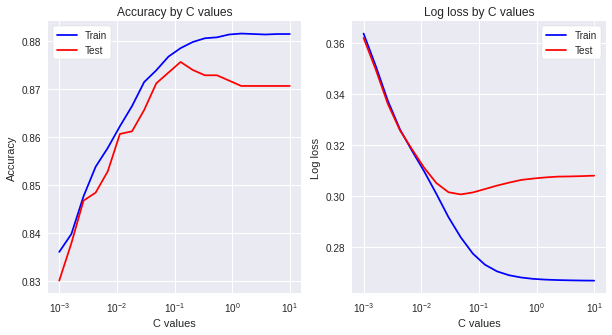

In [38]:
# visualize the results
visualize_C(C_range_feat_en, train_logLoss_feat_en, train_accuracy_feat_en, test_logLoss_feat_en, 
            test_accuracy_feat_en)

In [39]:
make_table(C_range_feat_en, train_logLoss_feat_en, train_accuracy_feat_en, test_logLoss_feat_en, 
           test_accuracy_feat_en)

     C_values  train_accuracy  train_log_loss  test_accuracy  test_log_loss
0    0.001000        0.835980        0.363870       0.830000       0.362136
1    0.001624        0.839706        0.351151       0.837778       0.349699
2    0.002637        0.847549        0.337403       0.846667       0.336134
3    0.004281        0.853725        0.326133       0.848333       0.325772
4    0.006952        0.857647        0.317658       0.852778       0.318242
5    0.011288        0.862157        0.309561       0.860556       0.311006
6    0.018330        0.866373        0.300764       0.861111       0.305030
7    0.029764        0.871373        0.291585       0.865556       0.301424
8    0.048329        0.873824        0.283731       0.871111       0.300573
9    0.078476        0.876667        0.277294       0.873333       0.301341
10   0.127427        0.878431        0.272921       0.875556       0.302683
11   0.206914        0.879706        0.270280       0.873889       0.304051
12   0.33598

In [ ]:
# tune max_iter parameter
best_C_feat_en = C_range_feat_en[10] # using the same process as previous models, we choose the best C value
maxiter_feat_en = np.linspace(10, 300, 30)

iter_train_logLoss_feat_en, iter_train_accuracy_feat_en, iter_test_logLoss_feat_en, iter_test_accuracy_feat_en = best_iter(
    maxiter_feat_en, best_C_feat_en, feat_x_train, feat_x_test, feat_y_train,feat_y_test, 'saga', 'elasticnet', elasticnet=True, l1_ratio=0.3)

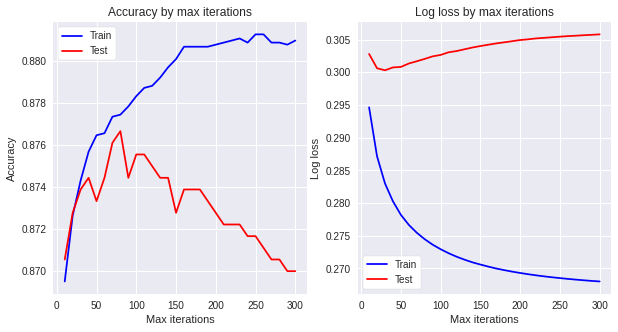

In [61]:
visualize_iter(maxiter_feat_en, iter_train_logLoss_feat_en, iter_train_accuracy_feat_en, iter_test_logLoss_feat_en, iter_test_accuracy_feat_en)

**DISCUSS:** Similar to l2 model, this model shows strong signs of overfitting after max_iter of ~60-70. With the same number of iterations, l2 model achieves higher accuracy scores and lower log loss, so we prefer l2 model to elasticnet model. It's also worth pointing out that this model achieves better accuracy than elasticnet model from the no added feature dataset.

Overall, after examining all the models, the model with regularization l2, fitted on the boxcox-transformed dataset with 2 added features, num_spots and sleeve_pixels performs best, with both high testing and training accuracy and relatively low max_iterations, at which point the model doesn't overfit the data (the gap between the 2 accuracy scores is arguably one of the narrowest of all), and the log loss is also one of the smallest out of all the models. We are going to use this model to predict the labels for our test set.

### Analysis and comparison to the base model

In [78]:
# refit the improved model with logistic regression CV
improved_lrcv = LogisticRegressionCV(Cs=[best_C_feat_l2], max_iter=50, solver='sag', penalty='l2', cv=4)
improved_lrcv.fit(feat_x_train, feat_y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was re

LogisticRegressionCV(Cs=[0.02069138081114789], class_weight=None, cv=4,
                     dual=False, fit_intercept=True, intercept_scaling=1.0,
                     l1_ratios=None, max_iter=50, multi_class='auto',
                     n_jobs=None, penalty='l2', random_state=None, refit=True,
                     scoring=None, solver='sag', tol=0.0001, verbose=0)

In [81]:
# calculate the cross validated scores of this improved model
calc_metrics(improved_lrcv, feat_x_train, feat_y_train, feat_x_test, feat_y_test)

The training AUC score is 0.9535112420029527
The testing AUC score is 0.9439352766798419

The training accuracy is: 0.8774509803921569
The testing accuracy is: 0.8777777777777778


(0.8774509803921569, 0.8777777777777778)

In [82]:
# reprint the scores of the baseline model
calc_metrics(base_lrcv, X_train_base, y_train_base, X_test_base, y_test_base)

The training AUC score is 0.9432722533218505
The testing AUC score is 0.9381472332015811

The training accuracy is: 0.8701960784313726
The testing accuracy is: 0.8611111111111112


(0.8701960784313726, 0.8611111111111112)

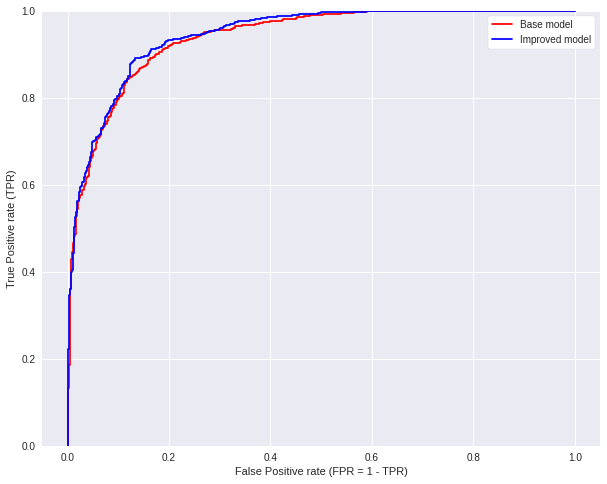

In [86]:
# visualize the ROC curves of both models
base_test_proba = base_lrcv.predict_proba(X_test_base)[:,1]
improved_test_proba = improved_lrcv.predict_proba(feat_x_test)[:,1]

base_fpr, base_tpr, base_thr = roc_curve(y_test_base, base_test_proba)
improved_fpr, improved_tpr, improved_thr = roc_curve(feat_y_test, improved_test_proba)

fig, ax = plt.subplots(sharey=True, figsize=(10, 8))
ax.plot(base_fpr, base_tpr, color='red', label="Base model")
ax.plot(improved_fpr, improved_tpr, color='blue', label ="Improved model")
plt.xlabel('False Positive rate (FPR = 1 - TPR)');
plt.ylabel('True Positive rate (TPR)');
plt.legend(frameon=True, framealpha=1,facecolor='white')
plt.ylim([0, 1]);
plt.show()

In [87]:
# predict the classes of the testing data of both models
base_test_preds = base_lrcv.predict(X_test_base)
improved_test_preds = improved_lrcv.predict(feat_x_test)

In [88]:
# print the confusion matrices of both models on test set
print("Confusion matrix of base model for testing set:")
base_md_test_cm = confusion_matrix(y_test_base, base_test_preds)
base_md_test_cm_df = pd.DataFrame(data=base_md_test_cm, columns=[0, 1], index=[0, 1])
base_md_test_cm_df.columns.name = 'Predicted'
base_md_test_cm_df.index.name = 'True'
print(base_md_test_cm_df)
print("------------------------------")
print("Confusion matrix of improved model for testing set:")
improved_md_test_cm = confusion_matrix(feat_y_test, improved_test_preds)
improved_md_test_cm_df = pd.DataFrame(data=improved_md_test_cm, columns=[0, 1], index=[0, 1])
improved_md_test_cm_df.columns.name = 'Predicted'
improved_md_test_cm_df.index.name = 'True'
print(improved_md_test_cm_df)

Confusion matrix of base model for testing set:
Predicted    0    1
True               
0          784  136
1          114  766
------------------------------
Confusion matrix of improved model for testing set:
Predicted    0    1
True               
0          796  124
1           96  784


In [89]:
# print the classification report of both models on test set
print("Analysis of predictions of base model on testing set:")
print(classification_report(y_test_base, base_test_preds))
print("----------------------------------------")
print("Analysis of predictions of improved model on testing set:")
print(classification_report(feat_y_test, improved_test_preds))

Analysis of predictions of base model on testing set:
              precision    recall  f1-score   support

           0       0.87      0.85      0.86       920
           1       0.85      0.87      0.86       880

    accuracy                           0.86      1800
   macro avg       0.86      0.86      0.86      1800
weighted avg       0.86      0.86      0.86      1800

----------------------------------------
Analysis of predictions of improved model on testing set:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88       920
           1       0.86      0.89      0.88       880

    accuracy                           0.88      1800
   macro avg       0.88      0.88      0.88      1800
weighted avg       0.88      0.88      0.88      1800



**DISCUSS:** The figure of the ROC curves on testing set for both models are really close to each other. The AUC score of the improved model is slightly better than that of the baseline model, which explains why the curve for the improved model (blue curve) bends towards the corner more, and it also reaches 1.0 TPR faster than the base model curve. 

Looking at the next 2 figures, we can see that the improved model makes fewer false positives and false negatives than the baseline models, and subsequently, achieving a higher scores on both precision and recall. In general, we lift the metrics up by 1-3% with the improved model.

## 4. Predict

In this last part, we transform the test data provided to have the appropriate forms for our model, and save the probabilities predicted to a text file.

In [91]:
# count the total dark pixels on the unlabeled testing data
num_spots_unlabeled = []
for img in range(len(test_shirt_x)):
    count = count_spot(test_shirt_x.iloc[img,:])
    num_spots_unlabeled.append(count)

In [92]:
unlabeled_data = test_shirt_x.copy()
unlabeled_data['num_spots'] = num_spots_unlabeled

In [93]:
# counting the number of dark pixels around the sleeve area of one side
count_pixel_unlabeled = []
for i in range(int(len(test_shirt_x))):
    img = test_shirt_x.iloc[i,:784].to_numpy().reshape(28,28)
    slev = img[:, :7]
    slev = slev.reshape(196, 1).transpose().flatten()
    num_pixel = count_spot_sleeve(slev)
    count_pixel_unlabeled.append(num_pixel)

In [95]:
unlabeled_data['one_sleeve_pixel'] = count_pixel_unlabeled
unlabeled_data

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,pixel010,pixel011,pixel012,pixel013,pixel014,pixel015,pixel016,pixel017,pixel018,pixel019,pixel020,pixel021,pixel022,pixel023,pixel024,pixel025,pixel026,pixel027,pixel028,pixel029,pixel030,pixel031,pixel032,pixel033,pixel034,pixel035,pixel036,pixel037,pixel038,pixel039,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots,one_sleeve_pixel
0,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1757,0.4492,0.3577,0.2510,0.1686,0.1725,0.2235,0.2627,0.3059,0.4228,0.5455,0.3532,0.0558,0.0,0.0000,0.00,0.0909,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.1569,0.4314,0.5608,0.4157,0.4275,0.4000,...,0.2667,0.3059,0.3412,0.3961,0.0588,0.0000,0.0042,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.0000,0.0413,0.2042,0.2367,0.3293,0.292,0.2784,0.2932,0.2824,0.2857,0.3004,0.3038,0.2869,0.2437,0.2426,0.2325,0.0090,0.0000,0.0000,0.0000,0.0,0.0,503,26
1,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.6667,0.8549,0.6980,0.6549,0.6980,0.7333,0.7236,0.0000,0.0000,0.0000,0.0,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.3098,0.7647,...,0.6078,0.6078,0.6549,0.7098,0.2431,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.3412,0.4545,0.4250,0.4163,0.4228,0.464,0.4667,0.4980,0.4980,0.4802,0.4650,0.4895,0.4768,0.4496,0.4809,0.6447,0.4574,0.0000,0.0000,0.0000,0.0,0.0,414,7
2,0.0,0.0,0.0385,0.0000,0.0000,0.0088,0.0045,0.0000,0.0000,0.0000,0.2236,0.7725,0.5882,0.3608,0.2392,0.2392,0.5843,0.9350,0.0672,0.0000,0.0000,0.0,0.0000,0.02,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0078,0.4314,0.8784,0.9882,0.8784,...,0.9137,0.8863,1.0000,0.0706,0.0000,0.0197,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.0000,0.0000,0.2833,0.9020,0.8821,0.876,0.8314,0.8514,0.8431,0.8571,0.9053,0.8987,0.8059,0.7143,0.3447,0.0000,0.0000,0.0059,0.0000,0.0000,0.0,0.0,487,45
3,0.0,0.0,0.0000,0.0435,0.0044,0.0000,0.0045,0.0000,0.0000,0.0000,0.0732,0.2784,0.2118,0.1529,0.1333,0.1333,0.2667,0.2602,0.0395,0.0000,0.0000,0.0,0.0000,0.01,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0044,0.0,0.0000,0.0314,0.2118,0.4078,0.4275,0.4667,...,0.4157,0.4039,0.1804,0.0000,0.0000,0.0039,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.0000,0.0041,0.0000,0.0000,0.0650,0.156,0.2314,0.2490,0.2863,0.3373,0.2840,0.2025,0.1139,0.0000,0.0000,0.0000,0.0045,0.0059,0.0000,0.0000,0.0,0.0,484,48
4,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0092,0.0000,0.0000,0.2980,0.5098,0.0000,0.1725,0.1693,0.0000,0.0225,0.0000,0.0000,0.0,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0118,0.0000,0.7373,...,0.0157,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0357,0.008,0.0000,0.0000,0.0094,0.0000,0.0000,0.0000,0.000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0165,0.0318,0.0095,0.0,0.0,499,82
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.0,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.1748,0.3569,0.1686,0.1804,0.1882,0.4549,0.2902,0.0000,0.0000,0.0000,0.0047,0.0,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0000,0.0,0.0000,0.0000,0.0000,0.0000,0.6314,0.6902,...,0.7490,0.8745,0.0510,0.0000,0.0039,0.0039,0.0000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.0000,0.0902,0.2975,0.3583,0.4612,0.4756,0.508,0.4667,0.4739,0.4745,0.4841,0.5226,0.5401,0

In [96]:
# transform the data with boxcox
unlabeled_data_boxcox = boxcox(unlabeled_data, 0.3) 
unlabeled_data_boxcox

,pixel000,pixel001,pixel002,pixel003,pixel004,pixel005,pixel006,pixel007,pixel008,pixel009,pixel010,pixel011,pixel012,pixel013,pixel014,pixel015,pixel016,pixel017,pixel018,pixel019,pixel020,pixel021,pixel022,pixel023,pixel024,pixel025,pixel026,pixel027,pixel028,pixel029,pixel030,pixel031,pixel032,pixel033,pixel034,pixel035,pixel036,pixel037,pixel038,pixel039,...,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,num_spots,one_sleeve_pixel
0,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-1.354951,-0.711466,-0.884640,-1.131518,-1.379282,-1.365830,-1.206850,-1.101217,-0.996904,-0.758677,-0.554150,-0.893922,-1.930943,-3.333333,-3.333333,-3.333333,-1.709850,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-1.420991,-0.743077,-0.530991,-0.771725,-0.750124,-0.801141,...,-1.091075,-0.996904,-0.919088,-0.808573,-1.908737,-3.333333,-2.687897,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.051995,-1.263690,-1.169926,-0.944663,-1.029274,-1.062007,-1.026438,-1.052266,-1.044302,-1.009587,-1.001728,-1.041421,-1.150928,-1.153888,-1.181515,-2.522089,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,18.211798,5.525382
1,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-0.381731,-0.153141,-0.340825,-0.397501,-0.340825,-0.296204,-0.308313,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-0.988008,-0.257760,...,-0.462507,-0.462507,-0.397501,-0.325737,-1.152541,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-0.919088,-0.702224,-0.754665,-0.770616,-0.758677,-0.685844,-0.681232,-0.629079,-0.629079,-0.658447,-0.684134,-0.643010,-0.664143,-0.710766,-0.657277,-0.411294,-0.697199,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,16.989247,2.642633
2,-3.333333,-3.333333,-2.078700,-3.333333,-3.333333,-2.527540,-2.674398,-3.333333,-3.333333,-3.333333,-1.206565,-0.248382,-0.490599,-0.878293,-1.163097,-1.163097,-0.496267,-0.066536,-1.850510,-3.333333,-3.333333,-3.333333,-3.333333,-2.302502,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.556179,-0.743077,-0.127164,-0.011849,-0.127164,...,-0.089042,-0.118541,0.000000,-1.828390,-3.333333,-2.307165,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-1.050087,-0.101561,-0.123119,-0.129795,-0.179623,-0.157053,-0.166374,-0.150688,-0.098019,-0.105113,-0.208959,-0.320029,-0.911685,-3.333333,-3.333333,-2.618616,-3.333333,-3.333333,-3.333333,-3.333333,18.003867,7.110081
3,-3.333333,-3.333333,-3.333333,-2.031889,-2.678826,-3.333333,-2.674398,-3.333333,-3.333333,-3.333333,-1.811973,-1.062007,-1.240876,-1.435749,-1.512259,-1.512259,-1.091075,-1.107611,-2.069011,-3.333333,-3.333333,-3.333333,-3.333333,-2.496038,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.678826,-3.333333,-3.333333,-2.153128,-1.240876,-0.786427,-0.750124,-0.681232,...,-0.771725,-0.793759,-1.339221,-3.333333,-3.333333,-2.702088,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-3.333333,-2.692546,-3.333333,-3.333333,-1.865243,-1.424289,-1.184574,-1.136796,-1.042860,-0.927400,-1.048396,-1.268874,-1.596189,-3.333333,-3.333333,-3.333333,-2.674398,-2.618616,-3.333333,-3.333333,-3.333333,-3.333333,17.964349,7.314252
4,-3.333333,-3.333333,-3.333333,-3.333333,-3.33

In [99]:
# predict the probabilities and save to text file
yproba1_test = improved_lrcv.predict_proba(unlabeled_data_boxcox)[:, 1]
np.savetxt('yproba1_test.txt', yproba1_test)